In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def generate_matrix_with_spectrum(eigenvalues, symmetric=True, device='cpu'):
    """
    Generate a symmetric matrix A = Q diag(eigenvalues) Q^T.
    """
    n = len(eigenvalues)
    # Generate a random orthogonal matrix Q via QR factorization.
    Q, _ = torch.linalg.qr(torch.randn(n, n, device=device))
    D = torch.diag(eigenvalues.clone().detach())
    if symmetric:
        A = Q @ D @ Q.T
    else:
        P = torch.randn(n, n)
        while torch.linalg.matrix_rank(P) < n:  # Ensure P is invertible
            P = torch.randn(n, n)
        A = P @ D @ torch.linalg.inv(P)
    return A

def compute_relative_error(A, A_approx, norm_type='fro'):
    """
    Compute the relative error ||A - A_approx||/||A||.
    norm_type: 'fro' for Frobenius or 2 for spectral norm.
    """
    return np.linalg.norm((A - A_approx), norm_type) \
            / np.linalg.norm(A, norm_type)

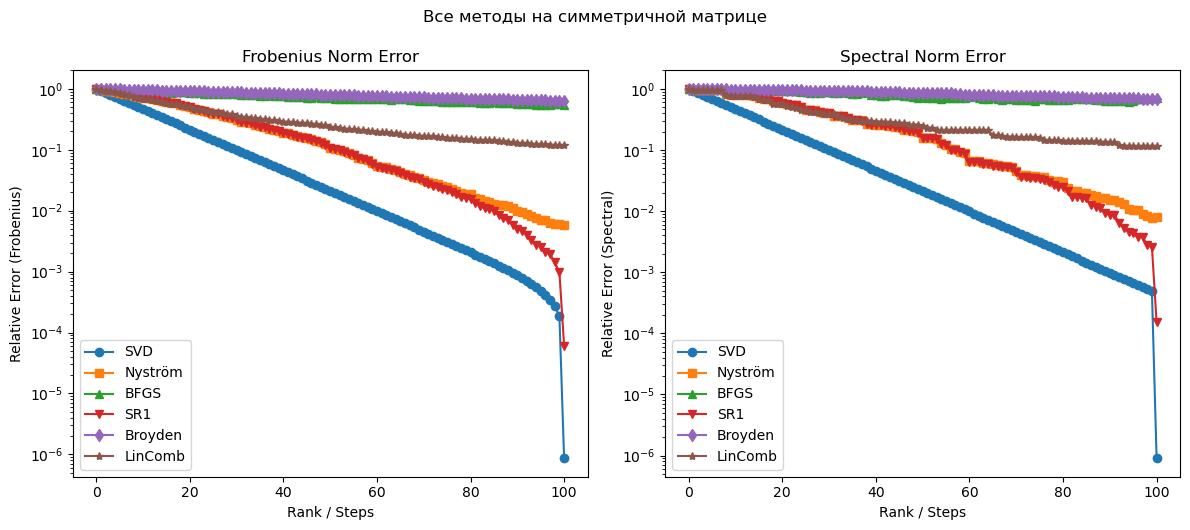

In [3]:
def truncated_svd_approximation(A, rank):
    """
    Compute the best rank-(rank) approximation of A using truncated SVD.
    """
    U, S, Vh = torch.linalg.svd(A)
    U_trunc = U[:, :rank]
    S_trunc = S[:rank]
    Vh_trunc = Vh[:rank, :]
    A_approx = U_trunc @ torch.diag(S_trunc) @ Vh_trunc
    return A_approx

def nystrom_approximation(A, S):
    """
    Compute a Nyström approximation.
    
    Given a landmark matrix S (whose columns are the s–vectors),
    define Y = A S and W = S^T A S. Then approximate A as:
      A_approx = Y W^† Y^T.
    """
    Y = A @ S
    W = S.T @ Y  # = S^T A S
    W_pinv = torch.linalg.pinv(W)
    A_approx = Y @ W_pinv @ Y.T
    return A_approx

def bfgs_approximation(s, y, B):
    """
    Build an approximation using the BFGS update formula.
    
    Starting with an initial B0 = gamma * I (with gamma from the first pair)
    and then updating with
      B <- B - (B s s^T B)/(s^T B s) + (y y^T)/(y^T s).
    """
    # if len(s_list) > 0:
    #     s0 = s_list[0]
    #     y0 = y_list[0]
    #     gamma = (y0 @ s0) / (s0 @ s0)
    # else:
    #     gamma = 1.0
    # device = s_list[0].device if len(s_list) > 0 else 'cpu'
    # gamma = 1
    # B = gamma * torch.eye(n, device=device)
    # for s, y in zip(s_list, y_list):
    s = s.view(-1, 1)
    y = y.view(-1, 1)
    Bs = B @ s
    denom1 = (s.T @ Bs).item()
    if abs(denom1) < 1e-5:
        return B
    term1 = (Bs @ Bs.T) / denom1
    denom2 = (y.T @ s).item()
    if abs(denom2) < 1e-5:
        return B
    term2 = (y @ y.T) / denom2
    B = B - term1 + term2
    return B

def sr1_approximation(s, y, B):
    """
    Build an approximation using the SR1 update:
      B <- B + ((y - B s)(y - B s)^T)/( (y - B s)^T s ).
    """
    # device = s_list[0].device if len(s_list) > 0 else 'cpu'
    # B = torch.eye(n, device=device)
    # for s, y in zip(s_list, y_list):
    s = s.view(-1, 1)
    y = y.view(-1, 1)
    Bs = B @ s
    diff = y - Bs
    denom = (diff.T @ s).item()
    if abs(denom) < 1e-5:
        return B
    update = (diff @ diff.T) / denom
    B = B + update
    return B

def broyden_approximation(s, y, B):
    """
    Build an approximation using a Broyden update:
      B <- B + ((y - B s) s^T)/(s^T s).
    """
    # device = s_list[0].device if len(s_list) > 0 else 'cpu'
    # B = torch.eye(n, device=device)
    # for s, y in zip(s_list, y_list):
    s = s.view(-1, 1)
    y = y.view(-1, 1)
    Bs = B @ s
    diff = y - Bs
    denom = (s.T @ s).item()
    if abs(denom) < 1e-5:
        return B
    update = (diff @ s.T) / denom
    B = B + update
    return B

def linear_combination_approximation(s, y, B, A):
    """
    Approximate A as a linear combination of basis matrices built
    from the s and y vectors. For each pair (s,y) we include four bases:
    
        M1 = s s^T,  M2 = s y^T,  M3 = y s^T,  M4 = y y^T.
    
    We solve for coefficients c minimizing ||A - sum_i c_i M_i||_F.
    """
    n = s.shape[0]
    basis_matrices = []
    # B = torch.eye(n, device=device)
    # for s, y in zip(s_list, y_list):
    s = s.view(-1, 1)
    y = y.view(-1, 1)
    Bs = B @ s
    BTs = B.T @ s
    basis_matrices = [
                        Bs @ Bs.T, 
                        Bs @ y.T,
                        y @ Bs.T, 
                        y @ y.T,
                        s @ s.T,
                        s @ y.T, 
                        y @ s.T,
                        s @ Bs.T, 
                        Bs @ s.T,
                        # B
                        BTs @ BTs.T, 
                        BTs @ y.T,
                        y @ BTs.T, 
                        y @ y.T,
                        s @ s.T,
                        s @ y.T, 
                        y @ s.T,
                        s @ BTs.T, 
                        BTs @ s.T,
                      ]
    for i, b in enumerate(basis_matrices):
            basis_matrices[i] /= torch.linalg.norm(b)
    # Stack flattened basis matrices as columns in a matrix B_mat.
    B_mat = torch.stack([M.reshape(-1) for M in basis_matrices], dim=1)  # shape: (n*n, 4*m)
    A_vec = (A-B).reshape(-1, 1)
    # Solve the least squares problem B_mat c = A_vec.
    solution = torch.linalg.lstsq(B_mat, A_vec)
    c = solution.solution  # shape: (4*m, 1)
    # print(c)
    # Reconstruct the approximation.
    A_approx = B + (B_mat @ c).reshape((n, n))
        
    return A_approx


device = 'cpu'
torch.manual_seed(42)
n = 100
steps = n


eigenvalues = torch.tensor([] + list(2**torch.linspace(12, 1, n)))
A = generate_matrix_with_spectrum(eigenvalues, device=device)


ranks = list(range(0, steps+1))
errors_svd_fro = [1]
errors_svd_2   = [1]
errors_nystrom_fro = [1]
errors_nystrom_2   = [1]
errors_bfgs_fro = [1]
errors_bfgs_2   = [1]
errors_sr1_fro  = [1]
errors_sr1_2    = [1]
errors_broyden_fro = [1]
errors_broyden_2   = [1]
errors_lincomb_fro = [1]
errors_lincomb_2   = [1]

s = torch.randn(n, device=device)
y = A@s
S_nystrom = s.view(-1, 1)  # For Nystrom build a matrix whose columns are s's.
A_svd = torch.eye(n)
A_nystrom = torch.eye(n)
A_bfgs = torch.eye(n)
A_sr1 = torch.eye(n)
A_broyden = torch.eye(n)
A_lincomb = torch.eye(n)

for k in range(steps):
    # --- Truncated SVD (optimal) approximation with rank = k+1 ---
    A_svd = truncated_svd_approximation(A, rank=k+1)
    errors_svd_fro.append(compute_relative_error(A, A_svd, norm_type='fro'))
    errors_svd_2.append(compute_relative_error(A, A_svd, norm_type=2))
    
    # --- Nyström approximation ---
    A_nystrom = nystrom_approximation(A, S_nystrom)
    errors_nystrom_fro.append(compute_relative_error(A, A_nystrom, norm_type='fro'))
    errors_nystrom_2.append(compute_relative_error(A, A_nystrom, norm_type=2))
    
    # --- BFGS approximation ---
    A_bfgs = bfgs_approximation(s, y, A_bfgs)
    errors_bfgs_fro.append(compute_relative_error(A, A_bfgs, norm_type='fro'))
    errors_bfgs_2.append(compute_relative_error(A, A_bfgs, norm_type=2))
    
    # --- SR1 approximation ---
    A_sr1 = sr1_approximation(s, y, A_sr1)
    errors_sr1_fro.append(compute_relative_error(A, A_sr1, norm_type='fro'))
    errors_sr1_2.append(compute_relative_error(A, A_sr1, norm_type=2))
    
    # --- Broyden approximation ---
    A_broyden = broyden_approximation(s, y, A_broyden)
    errors_broyden_fro.append(compute_relative_error(A, A_broyden, norm_type='fro'))
    errors_broyden_2.append(compute_relative_error(A, A_broyden, norm_type=2))
    
    # --- Linear combination approximation ---
    A_lincomb = linear_combination_approximation(s, y, A_lincomb, A)
    errors_lincomb_fro.append(compute_relative_error(A, A_lincomb, norm_type='fro'))
    errors_lincomb_2.append(compute_relative_error(A, A_lincomb, norm_type=2))

    # Update the common s and y vectors.
    s = torch.randn(n)
    # s = y.clone()
    s = s / torch.norm(s)
    y = A @ s
    S_nystrom = torch.cat([S_nystrom, s.view(-1, 1)], dim=1)

# Plot the errors vs. rank/steps.
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.semilogy(ranks, (errors_svd_fro),      marker='o', label='SVD')
plt.semilogy(ranks, (errors_nystrom_fro),  marker='s', label='Nyström')
plt.semilogy(ranks, (errors_bfgs_fro),     marker='^', label='BFGS')
plt.semilogy(ranks, (errors_sr1_fro),      marker='v', label='SR1')
plt.semilogy(ranks, (errors_broyden_fro),  marker='d', label='Broyden')
plt.semilogy(ranks, (errors_lincomb_fro),  marker='*', label='LinComb')
plt.xlabel('Rank / Steps')
plt.ylabel('Relative Error (Frobenius)')
plt.title('Frobenius Norm Error')
plt.legend()

plt.subplot(1, 2, 2)
plt.semilogy(ranks, (errors_svd_2),      marker='o', label='SVD')
plt.semilogy(ranks, (errors_nystrom_2),  marker='s', label='Nyström')
plt.semilogy(ranks, (errors_bfgs_2),     marker='^', label='BFGS')
plt.semilogy(ranks, (errors_sr1_2),      marker='v', label='SR1')
plt.semilogy(ranks, (errors_broyden_2),  marker='d', label='Broyden')
plt.semilogy(ranks, (errors_lincomb_2),  marker='*', label='LinComb')
plt.xlabel('Rank / Steps')
plt.ylabel('Relative Error (Spectral)')
plt.title('Spectral Norm Error')
plt.legend()

plt.tight_layout()
plt.suptitle('Все методы на симметричной матрице', y=1.05)
plt.show()


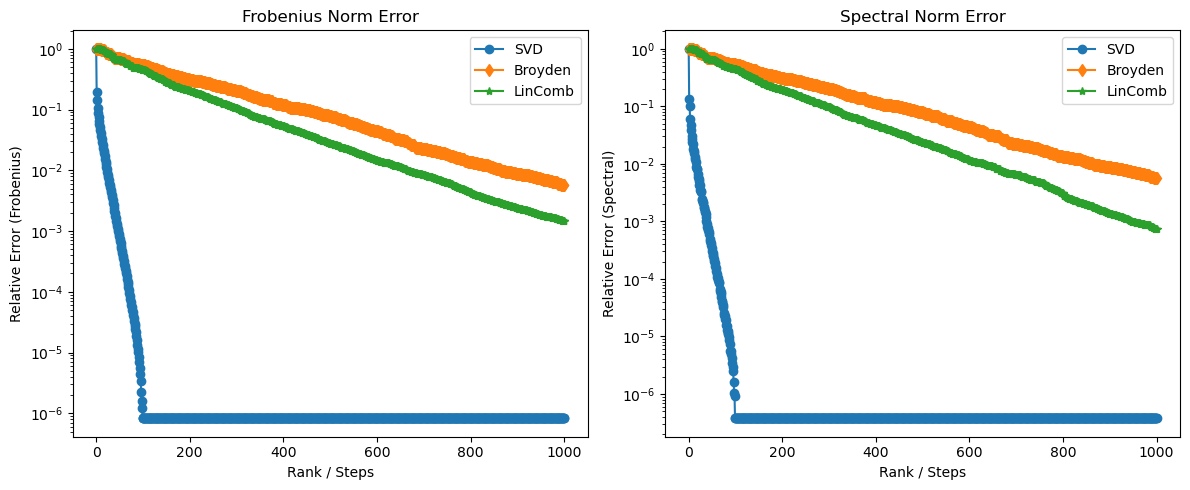

In [97]:
device = 'cpu'
torch.manual_seed(42)
n = 100
steps = 1000

eigenvalues = 2**torch.linspace(12, 1, n)
A = generate_matrix_with_spectrum(eigenvalues, symmetric=False, device=device)


ranks = list(range(0, steps+1))
errors_svd_fro = [1]
errors_svd_2   = [1]
errors_nystrom_fro = [1]
errors_nystrom_2   = [1]
errors_bfgs_fro = [1]
errors_bfgs_2   = [1]
errors_sr1_fro  = [1]
errors_sr1_2    = [1]
errors_broyden_fro = [1]
errors_broyden_2   = [1]
errors_lincomb_fro = [1]
errors_lincomb_2   = [1]

s = torch.randn(n, device=device)
y = A@s
S_nystrom = s.view(-1, 1)  # For Nystrom build a matrix whose columns are s's.
A_svd = torch.eye(n)
A_nystrom = torch.eye(n)
A_bfgs = torch.eye(n)
A_sr1 = torch.eye(n)
A_broyden = torch.eye(n)
A_lincomb = torch.eye(n)

for k in range(steps):
    # --- Truncated SVD (optimal) approximation with rank = k+1 ---
    A_svd = truncated_svd_approximation(A, rank=k+1)
    errors_svd_fro.append(compute_relative_error(A, A_svd, norm_type='fro'))
    errors_svd_2.append(compute_relative_error(A, A_svd, norm_type=2))
    
    # --- Nyström approximation ---
    # A_nystrom = nystrom_approximation(A, S_nystrom)
    # errors_nystrom_fro.append(compute_relative_error(A, A_nystrom, norm_type='fro'))
    # errors_nystrom_2.append(compute_relative_error(A, A_nystrom, norm_type=2))
    
    # --- BFGS approximation ---
    # A_bfgs = bfgs_approximation(s, y, A_bfgs)
    # errors_bfgs_fro.append(compute_relative_error(A, A_bfgs, norm_type='fro'))
    # errors_bfgs_2.append(compute_relative_error(A, A_bfgs, norm_type=2))
    
    # --- SR1 approximation ---
    # A_sr1 = sr1_approximation(s, y, A_sr1)
    # errors_sr1_fro.append(compute_relative_error(A, A_sr1, norm_type='fro'))
    # errors_sr1_2.append(compute_relative_error(A, A_sr1, norm_type=2))
    
    # --- Broyden approximation ---
    A_broyden = broyden_approximation(s, y, A_broyden)
    errors_broyden_fro.append(compute_relative_error(A, A_broyden, norm_type='fro'))
    errors_broyden_2.append(compute_relative_error(A, A_broyden, norm_type=2))
    
    # --- Linear combination approximation ---
    A_lincomb = linear_combination_approximation(s, y, A_lincomb, A)
    errors_lincomb_fro.append(compute_relative_error(A, A_lincomb, norm_type='fro'))
    errors_lincomb_2.append(compute_relative_error(A, A_lincomb, norm_type=2))

    # Update the common s and y vectors.
    s = torch.randn(n)
    # s = y.clone()
    s = s / torch.norm(s)
    y = A @ s
    S_nystrom = torch.cat([S_nystrom, s.view(-1, 1)], dim=1)

# Plot the errors vs. rank/steps.
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.semilogy(ranks, (errors_svd_fro),      marker='o', label='SVD')
# plt.plot(ranks, errors_nystrom_fro,  marker='s', label='Nyström')
# plt.plot(ranks, errors_bfgs_fro,     marker='^', label='BFGS')
# plt.plot(ranks, errors_sr1_fro,      marker='v', label='SR1')
plt.semilogy(ranks, (errors_broyden_fro),  marker='d', label='Broyden')
plt.semilogy(ranks, (errors_lincomb_fro),  marker='*', label='LinComb')
plt.xlabel('Rank / Steps')
plt.ylabel('Relative Error (Frobenius)')
plt.title('Frobenius Norm Error')
plt.legend()

plt.subplot(1, 2, 2)
plt.semilogy(ranks, (errors_svd_2),      marker='o', label='SVD')
# plt.plot(ranks, errors_nystrom_2,  marker='s', label='Nyström')
# plt.plot(ranks, errors_bfgs_2,     marker='^', label='BFGS')
# plt.plot(ranks, errors_sr1_2,      marker='v', label='SR1')
plt.semilogy(ranks, (errors_broyden_2),  marker='d', label='Broyden')
plt.semilogy(ranks, (errors_lincomb_2),  marker='*', label='LinComb')
plt.xlabel('Rank / Steps')
plt.ylabel('Relative Error (Spectral)')
plt.title('Spectral Norm Error')
plt.legend()

plt.tight_layout()
plt.show()

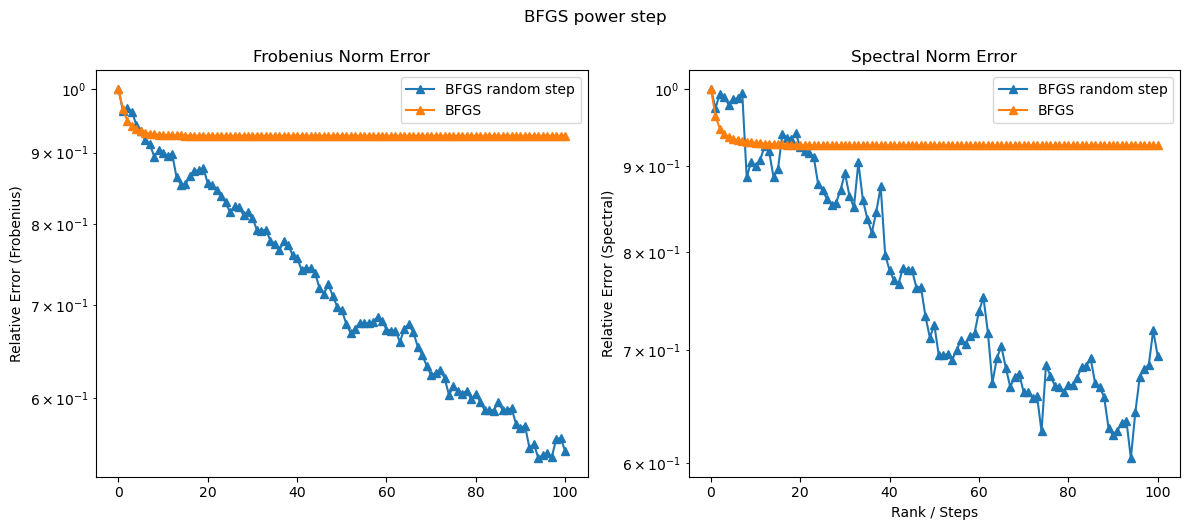

In [18]:
device = 'cpu'
torch.manual_seed(42)
n = 100
steps = 100

eigenvalues = 2**torch.linspace(12, 1, n)
A = generate_matrix_with_spectrum(eigenvalues, symmetric=True, device=device)


ranks = list(range(0, steps+1))
errors_bfgs_fro = [1]
errors_bfgs_2   = [1]
errors_bfgs_fro_norm = [1]
errors_bfgs_2_norm   = [1]

s = torch.randn(n, device=device)
y = A@s
A_bfgs = torch.eye(n)

for k in range(steps):    
    # --- BFGS approximation ---
    A_bfgs = bfgs_approximation(s, y, A_bfgs)
    errors_bfgs_fro.append(compute_relative_error(A, A_bfgs, norm_type='fro'))
    errors_bfgs_2.append(compute_relative_error(A, A_bfgs, norm_type=2))

    # Update the common s and y vectors.
    s = torch.randn(n)
    # s = y.clone()
    s = s / torch.norm(s)
    y = A @ s

s = torch.randn(n, device=device)
y = A@s
A_bfgs = torch.eye(n)

for k in range(steps):    
    # --- BFGS approximation ---
    A_bfgs = bfgs_approximation(s, y, A_bfgs)
    errors_bfgs_fro_norm.append(compute_relative_error(A, A_bfgs, norm_type='fro'))
    errors_bfgs_2_norm.append(compute_relative_error(A, A_bfgs, norm_type=2))

    # Update the common s and y vectors.
    s = torch.randn(n)
    s = y.clone()
    s = s / torch.norm(s)
    y = A @ s

# Plot the errors vs. rank/steps.
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.semilogy(ranks, (errors_bfgs_fro),     marker='^', label='BFGS random step')
plt.semilogy(ranks, (errors_bfgs_fro_norm),     marker='^', label='BFGS')
plt.ylabel('Relative Error (Frobenius)')
plt.title('Frobenius Norm Error')
plt.legend()

plt.subplot(1, 2, 2)
plt.semilogy(ranks, (errors_bfgs_2),     marker='^', label='BFGS random step')
plt.semilogy(ranks, (errors_bfgs_2_norm),     marker='^', label='BFGS')
plt.xlabel('Rank / Steps')
plt.ylabel('Relative Error (Spectral)')
plt.title('Spectral Norm Error')
plt.legend()

plt.tight_layout()
plt.suptitle('BFGS power step', y=1.05)
plt.show()

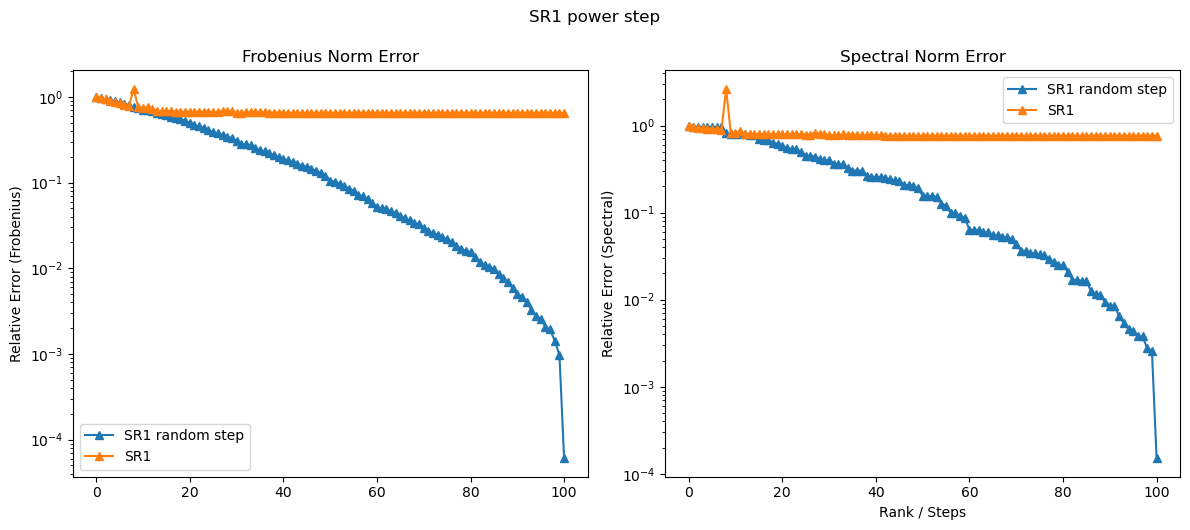

In [22]:
device = 'cpu'
torch.manual_seed(42)
n = 100
steps = 100

eigenvalues = 2**torch.linspace(12, 1, n)
A = generate_matrix_with_spectrum(eigenvalues, symmetric=True, device=device)


ranks = list(range(0, steps+1))
errors_sr1_fro = [1]
errors_sr1_2   = [1]
errors_sr1_fro_norm = [1]
errors_sr1_2_norm   = [1]

s = torch.randn(n, device=device)
y = A@s
A_sr1 = torch.eye(n)

for k in range(steps):    
    A_sr1 = sr1_approximation(s, y, A_sr1)
    errors_sr1_fro.append(compute_relative_error(A, A_sr1, norm_type='fro'))
    errors_sr1_2.append(compute_relative_error(A, A_sr1, norm_type=2))

    # Update the common s and y vectors.
    s = torch.randn(n)
    # s = y.clone()
    s = s / torch.norm(s)
    y = A @ s

s = torch.randn(n, device=device)
y = A@s
A_sr1 = torch.eye(n)

for k in range(steps):    
    A_sr1 = sr1_approximation(s, y, A_sr1)
    errors_sr1_fro_norm.append(compute_relative_error(A, A_sr1, norm_type='fro'))
    errors_sr1_2_norm.append(compute_relative_error(A, A_sr1, norm_type=2))

    # Update the common s and y vectors.
    s = torch.randn(n)
    s = y.clone()
    s = s / torch.norm(s)
    y = A @ s

# Plot the errors vs. rank/steps.
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.semilogy(ranks, errors_sr1_fro,     marker='^', label='SR1 random step')
plt.semilogy(ranks, errors_sr1_fro_norm,     marker='^', label='SR1')
plt.ylabel('Relative Error (Frobenius)')
plt.title('Frobenius Norm Error')
plt.legend()

plt.subplot(1, 2, 2)
plt.semilogy(ranks, errors_sr1_2,     marker='^', label='SR1 random step')
plt.semilogy(ranks, errors_sr1_2_norm,     marker='^', label='SR1')
plt.xlabel('Rank / Steps')
plt.ylabel('Relative Error (Spectral)')
plt.title('Spectral Norm Error')
plt.legend()

plt.tight_layout()
plt.suptitle('SR1 power step', y=1.05)
plt.show()

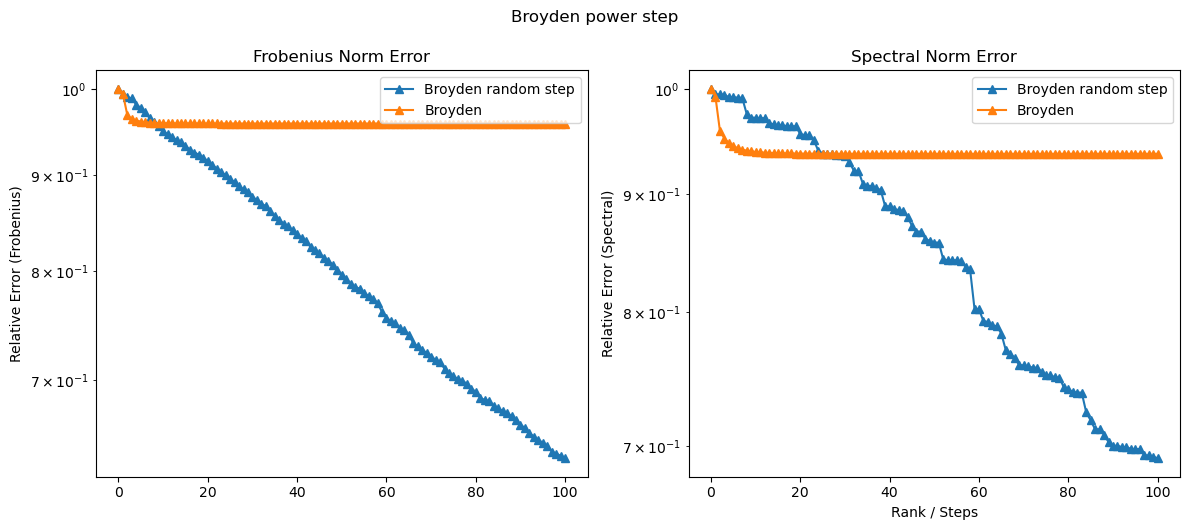

In [14]:
device = 'cpu'
torch.manual_seed(42)
n = 100
steps = 100

eigenvalues = 2**torch.linspace(12, 1, n)
A = generate_matrix_with_spectrum(eigenvalues, symmetric=True, device=device)


ranks = list(range(0, steps+1))
errors_broyden_fro = [1]
errors_broyden_2   = [1]
errors_broyden_fro_norm = [1]
errors_broyden_2_norm   = [1]

s = torch.randn(n, device=device)
y = A@s
A_broyden = torch.eye(n)

for k in range(steps):    
    A_broyden = broyden_approximation(s, y, A_broyden)
    errors_broyden_fro.append(compute_relative_error(A, A_broyden, norm_type='fro'))
    errors_broyden_2.append(compute_relative_error(A, A_broyden, norm_type=2))

    # Update the common s and y vectors.
    s = torch.randn(n)
    # s = y.clone()
    s = s / torch.norm(s)
    y = A @ s

s = torch.randn(n, device=device)
y = A@s
A_broyden = torch.eye(n)

for k in range(steps):    
    A_broyden = broyden_approximation(s, y, A_broyden)
    errors_broyden_fro_norm.append(compute_relative_error(A, A_broyden, norm_type='fro'))
    errors_broyden_2_norm.append(compute_relative_error(A, A_broyden, norm_type=2))

    # Update the common s and y vectors.
    s = torch.randn(n)
    s = y.clone()
    s = s / torch.norm(s)
    y = A @ s

# Plot the errors vs. rank/steps.
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.semilogy(ranks, (errors_broyden_fro),     marker='^', label='Broyden random step')
plt.semilogy(ranks, (errors_broyden_fro_norm),     marker='^', label='Broyden')
plt.ylabel('Relative Error (Frobenius)')
plt.title('Frobenius Norm Error')
plt.legend()

plt.subplot(1, 2, 2)
plt.semilogy(ranks, (errors_broyden_2),     marker='^', label='Broyden random step')
plt.semilogy(ranks, (errors_broyden_2_norm),     marker='^', label='Broyden')
plt.xlabel('Rank / Steps')
plt.ylabel('Relative Error (Spectral)')
plt.title('Spectral Norm Error')
plt.legend()

plt.tight_layout()
plt.suptitle('Broyden power step', y=1.05)
plt.show()

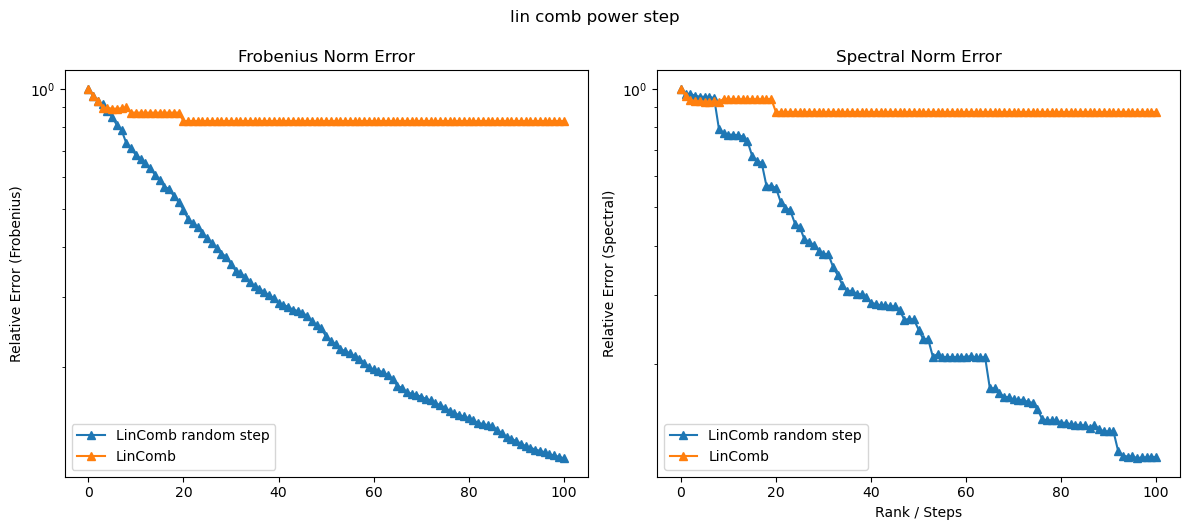

In [15]:
device = 'cpu'
torch.manual_seed(42)
n = 100
steps = 100

eigenvalues = 2**torch.linspace(12, 1, n)
A = generate_matrix_with_spectrum(eigenvalues, symmetric=True, device=device)


ranks = list(range(0, steps+1))
errors_lincomb_fro = [1]
errors_lincomb_2   = [1]
errors_lincomb_fro_norm = [1]
errors_lincomb_2_norm   = [1]

s = torch.randn(n, device=device)
y = A@s
A_lincomb = torch.eye(n)

for k in range(steps):    
    A_lincomb = linear_combination_approximation(s, y, A_lincomb, A)
    errors_lincomb_fro.append(compute_relative_error(A, A_lincomb, norm_type='fro'))
    errors_lincomb_2.append(compute_relative_error(A, A_lincomb, norm_type=2))

    # Update the common s and y vectors.
    s = torch.randn(n)
    # s = y.clone()
    s = s / torch.norm(s)
    y = A @ s

s = torch.randn(n, device=device)
y = A@s
A_lincomb = torch.eye(n)

for k in range(steps):    
    A_lincomb = linear_combination_approximation(s, y, A_lincomb, A)
    errors_lincomb_fro_norm.append(compute_relative_error(A, A_lincomb, norm_type='fro'))
    errors_lincomb_2_norm.append(compute_relative_error(A, A_lincomb, norm_type=2))

    # Update the common s and y vectors.
    s = torch.randn(n)
    s = y.clone()
    s = s / torch.norm(s)
    y = A @ s

# Plot the errors vs. rank/steps.
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.semilogy(ranks, (errors_lincomb_fro),     marker='^', label='LinComb random step')
plt.semilogy(ranks, (errors_lincomb_fro_norm),     marker='^', label='LinComb')
plt.ylabel('Relative Error (Frobenius)')
plt.title('Frobenius Norm Error')
plt.legend()

plt.subplot(1, 2, 2)
plt.semilogy(ranks, (errors_lincomb_2),     marker='^', label='LinComb random step')
plt.semilogy(ranks, (errors_lincomb_2_norm),     marker='^', label='LinComb')
plt.xlabel('Rank / Steps')
plt.ylabel('Relative Error (Spectral)')
plt.title('Spectral Norm Error')
plt.legend()

plt.tight_layout()
plt.suptitle('lin comb power step', y=1.05)
plt.show()

In [16]:
# Tест для Sr1: матрица, s = (1,0,0,...0), после одного шага 1 строка и столбец совпадают с изначальной
def sr1_approximation(s_list, y_list, n):
    """
    Build an approximation using the SR1 update:
      B <- B + ((y - B s)(y - B s)^T)/( (y - B s)^T s ).
    """
    device = s_list[0].device if len(s_list) > 0 else 'cpu'
    B = torch.ones(n, device=device)
    for s, y in zip(s_list, y_list):
        s = s.view(-1, 1)
        y = y.view(-1, 1)
        Bs = B @ s
        diff = y - Bs
        denom = (diff.T @ s).item()
        # print(denom)
        if abs(denom) < 1e-8:
            continue
        update = (diff @ diff.T) / denom
        B = B + update
    return B

n = 50
A = generate_matrix_with_spectrum(torch.Tensor([2**k for k in range(n)]), device=device)
s = torch.Tensor([1]+[0]*(n-1))
y = A @ s
s_list = []
y_list = []
s_list.append(s)
y_list.append(y)
sr1_approximation(s_list, y_list, n)

for k in range(1):
    # Update the common s and y vectors.
    s = y / torch.norm(y)
    y = A @ s
    s_list.append(s)
    y_list.append(y)
    A_sr1 = sr1_approximation(s_list, y_list, n)

torch.isclose(A[:, 0], A_sr1[:, 0]).sum() + torch.isclose(A[0, :], A_sr1[0, :]).sum() == 2*n

tensor(True)

### К 11.03.2025

1) Приближается по первому собственному числу, вектор $s$ совпадает с первым собственным
2) Для спектра с сильно выбивающимся первым собственным числом сразу хорошо приближаем
3) Минимальное СВ можно искать power method для $(A - \lambda I)$ или $A^{-1}$
4) Генерация ортогональных дает незначительно лучший результат, чем случайный
5) LinComb лучше остальных, если отнормировать матрицы перед поиском коэффициентов

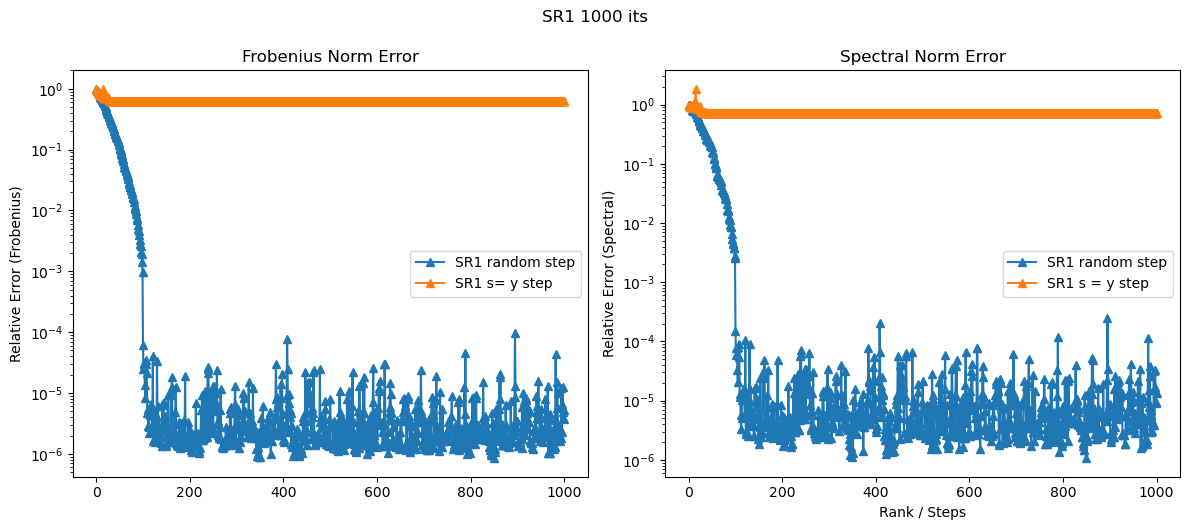

0.0 False True


In [25]:
device = 'cpu'
torch.manual_seed(42)
n = 100
steps = 1000

eigenvalues = 2**torch.linspace(12, 1, n)
A = generate_matrix_with_spectrum(eigenvalues, symmetric=True, device=device)


ranks = list(range(0, steps+1))
errors_bfgs_fro = [1]
errors_bfgs_2   = [1]
errors_bfgs_fro_norm = [1]
errors_bfgs_2_norm   = [1]

s = torch.randn(n, device=device)
y = A@s
A_bfgs = torch.eye(n)

for k in range(steps):    
    # --- BFGS approximation ---
    A_bfgs = sr1_approximation(s, y, A_bfgs)
    errors_bfgs_fro.append(compute_relative_error(A, A_bfgs, norm_type='fro'))
    errors_bfgs_2.append(compute_relative_error(A, A_bfgs, norm_type=2))

    # Update the common s and y vectors.
    s = torch.randn(n)
    s = s / torch.norm(s)
    y = A @ s

s = torch.randn(n, device=device)
y = A@s
A_bfgs = torch.eye(n)

for k in range(steps):    
    # --- BFGS approximation ---
    A_bfgs = sr1_approximation(s, y, A_bfgs)
    errors_bfgs_fro_norm.append(compute_relative_error(A, A_bfgs, norm_type='fro'))
    errors_bfgs_2_norm.append(compute_relative_error(A, A_bfgs, norm_type=2))

    # Update the common s and y vectors.
    s = y.clone()
    s = s / torch.norm(s)
    y = A @ s

# Plot the errors vs. rank/steps.
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.semilogy(ranks, errors_bfgs_fro,     marker='^', label='SR1 random step')
plt.semilogy(ranks, errors_bfgs_fro_norm,     marker='^', label='SR1 s= y step')
plt.ylabel('Relative Error (Frobenius)')
plt.title('Frobenius Norm Error')
plt.legend()

plt.subplot(1, 2, 2)
plt.semilogy(ranks, errors_bfgs_2,     marker='^', label='SR1 random step')
plt.semilogy(ranks, errors_bfgs_2_norm,     marker='^', label='SR1 s = y step')
plt.xlabel('Rank / Steps')
plt.ylabel('Relative Error (Spectral)')
plt.title('Spectral Norm Error')
plt.legend()

plt.tight_layout()
plt.suptitle('SR1 1000 its', y=1.05)
plt.show()
eigenvalues_A, eigenvectors_A = np.linalg.eig(A)
eigenvalues_bfgs, eigenvectors_bfgs = np.linalg.eig(A_bfgs)
print(eigenvalues_A[0] - eigenvalues_bfgs[0], 
      np.allclose(eigenvectors_bfgs[:, 0],eigenvectors_A[:, 0], rtol=0.05), 
      np.allclose(s,eigenvectors_A[:, 0], rtol=0.05))

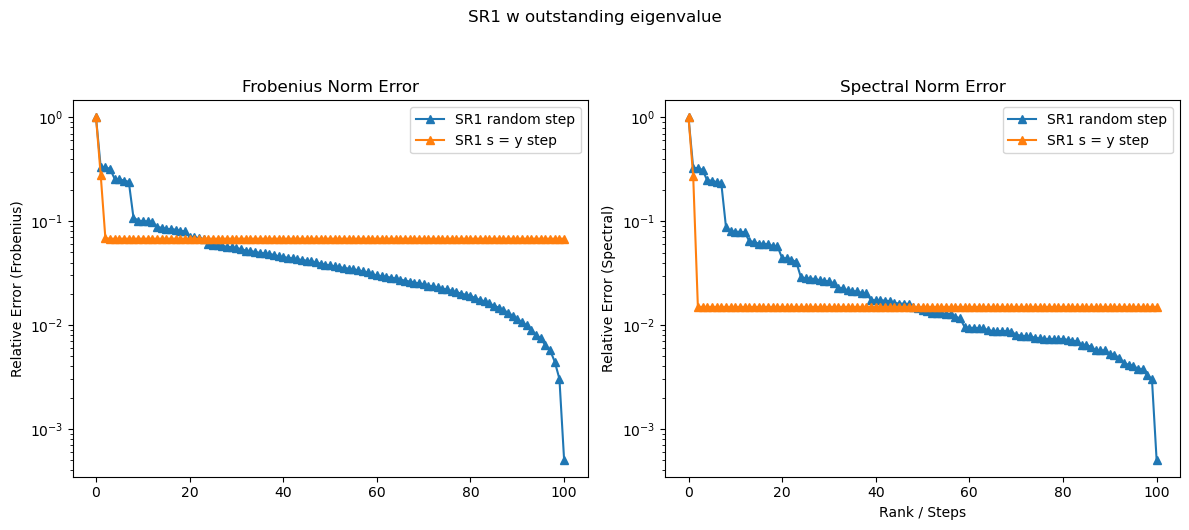

0.0 True True


In [26]:
device = 'cpu'
torch.manual_seed(42)
n = 100
steps = 100

eigenvalues = torch.tensor([1000] + list(2**torch.linspace(4, 1, n-1)))
A = generate_matrix_with_spectrum(eigenvalues, symmetric=True, device=device)


ranks = list(range(0, steps+1))
errors_bfgs_fro = [1]
errors_bfgs_2   = [1]
errors_bfgs_fro_norm = [1]
errors_bfgs_2_norm   = [1]

s = torch.randn(n, device=device)
y = A@s
A_bfgs = torch.eye(n)

for k in range(steps):    
    # --- BFGS approximation ---
    A_bfgs = sr1_approximation(s, y, A_bfgs)
    errors_bfgs_fro.append(compute_relative_error(A, A_bfgs, norm_type='fro'))
    errors_bfgs_2.append(compute_relative_error(A, A_bfgs, norm_type=2))

    # Update the common s and y vectors.
    s = torch.randn(n)
    s = s / torch.norm(s)
    y = (A) @ s

s = torch.randn(n, device=device)
y = A@s
A_bfgs = torch.eye(n)

for k in range(steps):    
    # --- BFGS approximation ---
    A_bfgs = sr1_approximation(s, y, A_bfgs)
    errors_bfgs_fro_norm.append(compute_relative_error(A, A_bfgs, norm_type='fro'))
    errors_bfgs_2_norm.append(compute_relative_error(A, A_bfgs, norm_type=2))

    # Update the common s and y vectors.
    s = y.clone()
    s = s / torch.norm(s)
    y = (A) @ s

# Plot the errors vs. rank/steps.
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.semilogy(ranks, (errors_bfgs_fro),     marker='^', label='SR1 random step')
plt.semilogy(ranks, (errors_bfgs_fro_norm),     marker='^', label='SR1 s = y step')
plt.ylabel('Relative Error (Frobenius)')
plt.title('Frobenius Norm Error')
plt.legend()

plt.subplot(1, 2, 2)
plt.semilogy(ranks[:], (errors_bfgs_2[:]),     marker='^', label='SR1 random step')
plt.semilogy(ranks[:], (errors_bfgs_2_norm[:]),     marker='^', label='SR1 s = y step')
plt.xlabel('Rank / Steps')
plt.ylabel('Relative Error (Spectral)')
plt.title('Spectral Norm Error')
plt.suptitle('SR1 w outstanding eigenvalue', y=1.05)
plt.legend()

plt.tight_layout()
plt.show()
eigenvalues_A, eigenvectors_A = np.linalg.eig(A)
eigenvalues_bfgs, eigenvectors_bfgs = np.linalg.eig(A_bfgs)
print(eigenvalues_A[0] - eigenvalues_bfgs[0], 
      np.allclose(eigenvectors_bfgs[:, 0],eigenvectors_A[:, 0], rtol=0.05), 
      np.allclose(s,eigenvectors_A[:, 0], rtol=0.05))

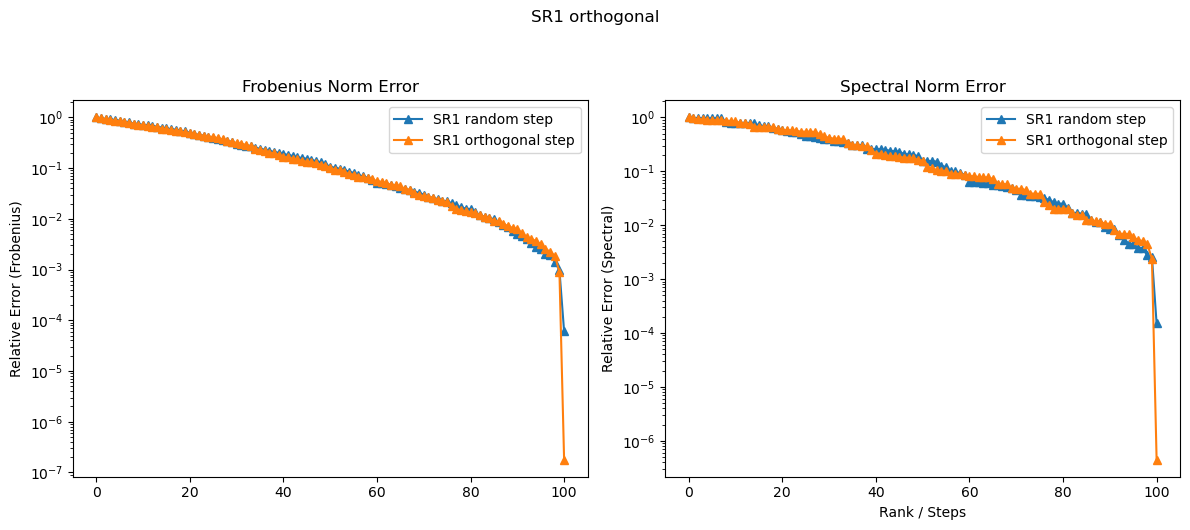

In [27]:
device = 'cpu'
torch.manual_seed(42)
n = 100
steps = 100

eigenvalues = 2**torch.linspace(12, 1, n)
A = generate_matrix_with_spectrum(eigenvalues, symmetric=True, device=device)


ranks = list(range(0, steps+1))
errors_bfgs_fro = [1]
errors_bfgs_2   = [1]
errors_bfgs_fro_norm = [1]
errors_bfgs_2_norm   = [1]

s = torch.randn(n, device=device)
y = A@s
A_bfgs = torch.eye(n)

for k in range(steps):    
    # --- BFGS approximation ---
    A_bfgs = sr1_approximation(s, y, A_bfgs)
    errors_bfgs_fro.append(compute_relative_error(A, A_bfgs, norm_type='fro'))
    errors_bfgs_2.append(compute_relative_error(A, A_bfgs, norm_type=2))

    # Update the common s and y vectors.
    s = torch.randn(n)
    s = s / torch.norm(s)
    y = (A) @ s

s = torch.randn(n, device=device)
y = A@s
A_bfgs = torch.eye(n)

for k in range(steps):    
    # --- BFGS approximation ---
    A_bfgs = sr1_approximation(s, y, A_bfgs)
    errors_bfgs_fro_norm.append(compute_relative_error(A, A_bfgs, norm_type='fro'))
    errors_bfgs_2_norm.append(compute_relative_error(A, A_bfgs, norm_type=2))

    # Update the common s and y vectors.
    s = torch.zeros(n)
    s[k] = 1
    y = (A) @ s

# Plot the errors vs. rank/steps.
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.semilogy(ranks, errors_bfgs_fro,     marker='^', label='SR1 random step')
plt.semilogy(ranks, errors_bfgs_fro_norm,     marker='^', label='SR1 orthogonal step')
plt.ylabel('Relative Error (Frobenius)')
plt.title('Frobenius Norm Error')
plt.legend()

plt.subplot(1, 2, 2)
plt.semilogy(ranks, errors_bfgs_2,     marker='^', label='SR1 random step')
plt.semilogy(ranks, errors_bfgs_2_norm,     marker='^', label='SR1 orthogonal step')
plt.xlabel('Rank / Steps')
plt.ylabel('Relative Error (Spectral)')
plt.title('Spectral Norm Error')
plt.suptitle('SR1 orthogonal', y=1.05)
plt.legend()

plt.tight_layout()
plt.show()

In [29]:
import numpy as np

def power_method(A, max_iter=1000, tol=1e-6):
    """Power method to find the dominant eigenvalue and eigenvector."""
    n = A.shape[0]
    b_k = np.random.rand(n).astype(np.float32)
    
    for i in range(max_iter):
        b_k1 = A @ b_k
        eigenvalue = (b_k1 @ b_k) / (b_k @ b_k)
        b_k1_norm = np.linalg.norm(b_k1)
        b_k_new = b_k1 / b_k1_norm
        
        if np.linalg.norm(b_k_new - b_k) < tol:
            return eigenvalue, b_k_new
        b_k = b_k_new
    
    return eigenvalue, b_k

def deflate_matrix(A, eigenvalue, eigenvector):
    """Deflate the matrix by removing the dominant eigen component."""
    return A - eigenvalue * np.outer(eigenvector, eigenvector)

def low_rank_approximation(A, rank, max_iter=100, tol=1e-6):
    """Approximate the matrix using top 'rank' eigenvalues/vectors via power iterations."""
    n = A.shape[0]
    approx = np.zeros_like(A)
    A_current = A.copy()
    
    for _ in range(rank):
        eigenvalue, eigenvector = power_method(A_current, max_iter, tol)
        approx += eigenvalue * np.outer(eigenvector, eigenvector)
        A_current = deflate_matrix(A_current, eigenvalue, eigenvector)
    
    return approx

# Example usage
if __name__ == "__main__":
    # Create a random symmetric matrix (for simplicity)
    np.random.seed(42)
    n = 5
    A = np.random.rand(n, n)
    A = A @ A.T  # Make it symmetric positive definite
    
    rank = 2  # Desired rank of approximation
    A_approx = low_rank_approximation(A, rank)
    
    print("Original Matrix:")
    print(A.round(4))
    print(f"\nRank-{rank} Approximation:")
    print(A_approx.round(4))
    
    # Compare with SVD (for validation)
    U, S, Vt = np.linalg.svd(A)
    S_rank = np.diag(S[:rank])
    U_rank = U[:, :rank]
    Vt_rank = Vt[:rank, :]
    A_svd_approx = U_rank @ S_rank @ Vt_rank
    
    print("\nSVD Rank-2 Approximation (for comparison):")
    print(A_svd_approx.round(4))

Original Matrix:
[[1.9627 1.218  1.6946 1.0461 0.8661]
 [1.218  1.6407 1.037  0.9667 0.8998]
 [1.6946 1.037  1.7123 0.8804 0.5518]
 [1.0461 0.9667 0.8804 0.673  0.599 ]
 [0.8661 0.8998 0.5518 0.599  0.8214]]

Rank-2 Approximation:
[[1.9004 1.2817 1.749  1.0418 0.7988]
 [1.2817 1.5495 0.9867 0.9589 1.0148]
 [1.749  0.9867 1.6638 0.8866 0.6012]
 [1.0418 0.9589 0.8866 0.6669 0.616 ]
 [0.7988 1.0148 0.6012 0.616  0.6666]]

SVD Rank-2 Approximation (for comparison):
[[1.9004 1.2817 1.749  1.0418 0.7988]
 [1.2817 1.5495 0.9867 0.9589 1.0148]
 [1.749  0.9867 1.6638 0.8866 0.6012]
 [1.0418 0.9589 0.8866 0.6669 0.616 ]
 [0.7988 1.0148 0.6012 0.616  0.6666]]


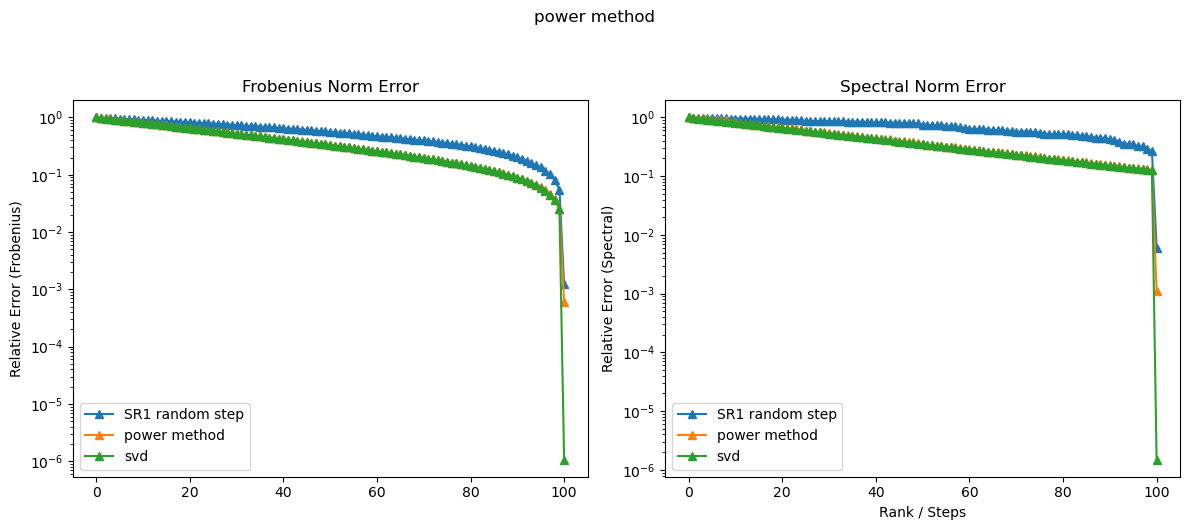

0.0022058487 False False


In [30]:
device = 'cpu'
torch.manual_seed(42)
n = 100
steps = 100

eigenvalues = torch.tensor(list(2**torch.linspace(4, 1, n)))
A = generate_matrix_with_spectrum(eigenvalues, symmetric=True, device=device)


ranks = list(range(0, steps+1))
errors_bfgs_fro = [1]
errors_bfgs_2   = [1]
errors_bfgs_fro_norm = [1]
errors_bfgs_2_norm   = [1]
errors_svd_fro = [1]
errors_svd_2 = [1]


s = torch.randn(n, device=device)
y = A@s
A_bfgs = torch.zeros(n)

for k in range(steps):    
    # --- BFGS approximation ---
    A_bfgs = sr1_approximation(s, y, A_bfgs)
    errors_bfgs_fro.append(compute_relative_error(A, A_bfgs, norm_type='fro'))
    errors_bfgs_2.append(compute_relative_error(A, A_bfgs, norm_type=2))

    # Update the common s and y vectors.
    s = torch.randn(n)
    s = s / torch.norm(s)
    y = A @ s

s = torch.randn(n, device=device)
y = A@s
A_bfgs = torch.zeros(n, n)
A_current = A.clone().detach()

for k in range(steps):    
    A_svd = truncated_svd_approximation(A, rank=k+1)
    errors_svd_fro.append(compute_relative_error(A, A_svd, norm_type='fro'))
    errors_svd_2.append(compute_relative_error(A, A_svd, norm_type=2))

    # A_bfgs += sr1_approximation(s, y, A_bfgs)
    eigenvalue, eigenvector = power_method(A-A_bfgs, 30, 1e-6)
    A_bfgs += eigenvalue * np.outer(eigenvector, eigenvector)
    errors_bfgs_fro_norm.append(compute_relative_error(A, A_bfgs, norm_type='fro'))
    errors_bfgs_2_norm.append(compute_relative_error(A, A_bfgs, norm_type=2))

    # Update the common s and y vectors.
    # s = eigenvector.clone()
    # s = s / torch.norm(s)
    # Bs = A_bfgs @ s
    # diff = y - Bs
    # denom = (diff.T @ s).item()
    # update = (diff @ diff.T) / denom
    # A_current = A_current - A_bfgs
    # y = (A - A_bfgs) @ s
    

# Plot the errors vs. rank/steps.
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.semilogy(ranks, errors_bfgs_fro,     marker='^', label='SR1 random step')
plt.semilogy(ranks, errors_bfgs_fro_norm,     marker='^', label='power method')
plt.semilogy(ranks, errors_svd_fro,     marker='^', label='svd')
plt.ylabel('Relative Error (Frobenius)')
plt.title('Frobenius Norm Error')
plt.legend()

plt.subplot(1, 2, 2)
plt.semilogy(ranks, errors_bfgs_2,     marker='^', label='SR1 random step')
plt.semilogy(ranks, errors_bfgs_2_norm,     marker='^', label='power method')
plt.semilogy(ranks, errors_svd_2,     marker='^', label='svd')
plt.xlabel('Rank / Steps')
plt.ylabel('Relative Error (Spectral)')
plt.title('Spectral Norm Error')
plt.suptitle('power method', y=1.05)
plt.legend()

plt.tight_layout()
plt.show()

eigenvalues_A, eigenvectors_A = np.linalg.eig(A)
eigenvalues_bfgs, eigenvectors_bfgs = np.linalg.eig(A_bfgs)
print(eigenvalues_A[0] - eigenvalues_bfgs[0], 
      np.allclose(eigenvectors_bfgs[:, 0],eigenvectors_A[:, 0], rtol=0.05), 
      np.allclose(s,eigenvectors_A[:, 0], rtol=0.05))

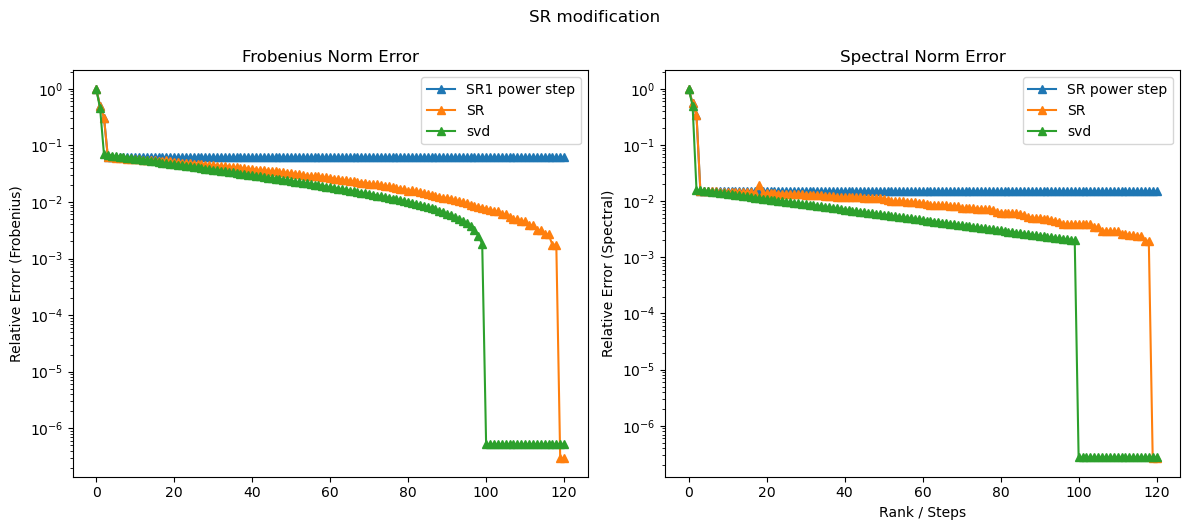

In [5]:
device = 'cpu'
torch.manual_seed(0)
n = 100
steps = 120

eigenvalues = torch.tensor([1000]+[500]+list(2**torch.linspace(4, 1, n-2)))
A = generate_matrix_with_spectrum(eigenvalues, symmetric=True, device=device)


ranks = list(range(0, steps+1))
errors_bfgs_fro = [1]
errors_bfgs_2   = [1]
errors_bfgs_fro_norm = [1]
errors_bfgs_2_norm   = [1]
errors_svd_fro = [1]
errors_svd_2 = [1]


s = torch.randn(n, device=device)
s0 = s.clone()
y = A@s
A_bfgs = torch.eye(n)

def sr1_approximation(s, y, B):
    """
    Build an approximation using the SR1 update:
      B <- B + ((y - B s)(y - B s)^T)/( (y - B s)^T s ).
    """
    s = s.view(-1, 1)
    y = y.view(-1, 1)
    diff = A@s - B @ s
    denom = (diff.T @ s).item()
    if abs(denom) < 1e-1:
        return B
    return B + (diff @ diff.T) / denom

def sr_approximation(s, y, B):
    """
    Build an approximation using the SR1 update:
      B <- B + ((y - B s)(y - B s)^T)/( (y - B s)^T s ).
    """
    s = s.view(-1, 1)
    y = y.view(-1, 1)
    denom = (y.T @ s).item()
    if abs(denom) < 1e-1:
        return B
    return B + y @ y.T / denom

for k in range(steps):    
    # --- BFGS approximation ---
    A_bfgs = sr1_approximation(s, y, A_bfgs)
    errors_bfgs_fro.append(compute_relative_error(A, A_bfgs, norm_type='fro'))
    errors_bfgs_2.append(compute_relative_error(A, A_bfgs, norm_type=2))

    # Update the common s and y vectors.
    # s = torch.randn(n)
    s = y.clone()
    s = s / torch.norm(s)
    y = A @ s

s = torch.randn(n, device=device)
s = s0.clone()
A_bfgs = torch.eye(n)
y = (A-A_bfgs)@s


for k in range(steps):    
    A_svd = truncated_svd_approximation(A, rank=k+1)
    errors_svd_fro.append(compute_relative_error(A, A_svd, norm_type='fro'))
    errors_svd_2.append(compute_relative_error(A, A_svd, norm_type=2))

    A_bfgs = sr_approximation(s, y, A_bfgs)
    errors_bfgs_fro_norm.append(compute_relative_error(A, A_bfgs, norm_type='fro'))
    errors_bfgs_2_norm.append(compute_relative_error(A, A_bfgs, norm_type=2))

    # Update the common s and y vectors.
    s = y.clone()
    s = s / torch.norm(s)
    y = (A - A_bfgs) @ s
    

# Plot the errors vs. rank/steps.
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.semilogy(ranks, errors_bfgs_fro,     marker='^', label='SR1 power step')
plt.semilogy(ranks, errors_bfgs_fro_norm,     marker='^', label='SR')
plt.semilogy(ranks, errors_svd_fro,     marker='^', label='svd')
plt.ylabel('Relative Error (Frobenius)')
plt.title('Frobenius Norm Error')
plt.legend()

plt.subplot(1, 2, 2)
plt.semilogy(ranks, errors_bfgs_2,     marker='^', label='SR power step')
plt.semilogy(ranks, errors_bfgs_2_norm,     marker='^', label='SR')
plt.semilogy(ranks, errors_svd_2,     marker='^', label='svd')
plt.xlabel('Rank / Steps')
plt.ylabel('Relative Error (Spectral)')
plt.title('Spectral Norm Error')
plt.legend()

plt.tight_layout()
plt.suptitle('SR modification', y=1.05)
plt.show()

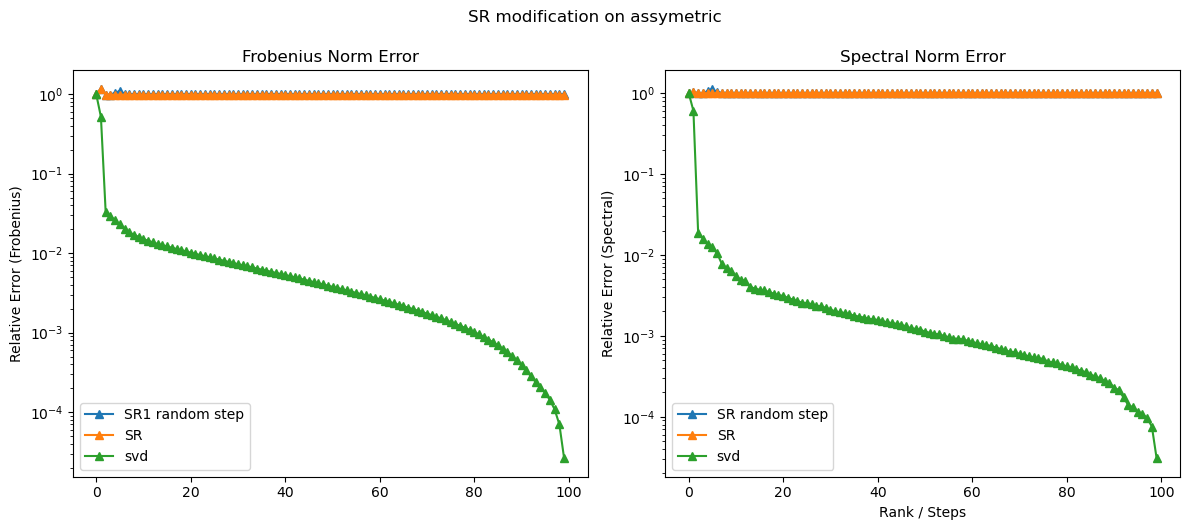

In [6]:
device = 'cpu'
torch.manual_seed(0)
n = 100
steps = 99

eigenvalues = torch.tensor([1000]+[500]+list(2**torch.linspace(4, 1, n-2)))
A = generate_matrix_with_spectrum(eigenvalues, symmetric=False, device=device)


ranks = list(range(0, steps+1))
errors_bfgs_fro = [1]
errors_bfgs_2   = [1]
errors_bfgs_fro_norm = [1]
errors_bfgs_2_norm   = [1]
errors_svd_fro = [1]
errors_svd_2 = [1]


s = torch.randn(n, device=device)
s0 = s.clone()
y = A@s
A_bfgs = torch.eye(n)

def sr1_approximation(s, y, B):
    """
    Build an approximation using the SR1 update:
      B <- B + ((y - B s)(y - B s)^T)/( (y - B s)^T s ).
    """
    s = s.view(-1, 1)
    y = y.view(-1, 1)
    diff = A@s - B @ s
    denom = (diff.T @ s).item()
    if abs(denom) < 1e-1:
        return B
    return B + (diff @ diff.T) / denom

def sr_approximation(s, y, B):
    """
    Build an approximation using the SR1 update:
      B <- B + ((y - B s)(y - B s)^T)/( (y - B s)^T s ).
    """
    s = s.view(-1, 1)
    y = y.view(-1, 1)
    denom = (y.T @ s).item()
    if abs(denom) < 1e-1:
        return B
    return B + y @ y.T / denom

for k in range(steps):    
    # --- BFGS approximation ---
    A_bfgs = sr1_approximation(s, y, A_bfgs)
    errors_bfgs_fro.append(compute_relative_error(A, A_bfgs, norm_type='fro'))
    errors_bfgs_2.append(compute_relative_error(A, A_bfgs, norm_type=2))

    # Update the common s and y vectors.
    # s = torch.randn(n)
    s = y.clone()
    s = s / torch.norm(s)
    y = A @ s

s = torch.randn(n, device=device)
s = s0.clone()
A_bfgs = torch.eye(n)
y = (A-A_bfgs)@s


for k in range(steps):    
    A_svd = truncated_svd_approximation(A, rank=k+1)
    errors_svd_fro.append(compute_relative_error(A, A_svd, norm_type='fro'))
    errors_svd_2.append(compute_relative_error(A, A_svd, norm_type=2))

    A_bfgs = sr_approximation(s, y, A_bfgs)
    errors_bfgs_fro_norm.append(compute_relative_error(A, A_bfgs, norm_type='fro'))
    errors_bfgs_2_norm.append(compute_relative_error(A, A_bfgs, norm_type=2))

    # Update the common s and y vectors.
    s = y.clone()
    s = s / torch.norm(s)
    y = (A - A_bfgs) @ s
    

# Plot the errors vs. rank/steps.
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.semilogy(ranks, errors_bfgs_fro,     marker='^', label='SR1 random step')
plt.semilogy(ranks, errors_bfgs_fro_norm,     marker='^', label='SR')
plt.semilogy(ranks, errors_svd_fro,     marker='^', label='svd')
plt.ylabel('Relative Error (Frobenius)')
plt.title('Frobenius Norm Error')
plt.legend()

plt.subplot(1, 2, 2)
plt.semilogy(ranks, errors_bfgs_2,     marker='^', label='SR random step')
plt.semilogy(ranks, errors_bfgs_2_norm,     marker='^', label='SR')
plt.semilogy(ranks, errors_svd_2,     marker='^', label='svd')
plt.xlabel('Rank / Steps')
plt.ylabel('Relative Error (Spectral)')
plt.title('Spectral Norm Error')
plt.legend()

plt.tight_layout()
plt.suptitle('SR modification on assymetric', y=1.05)
plt.show()

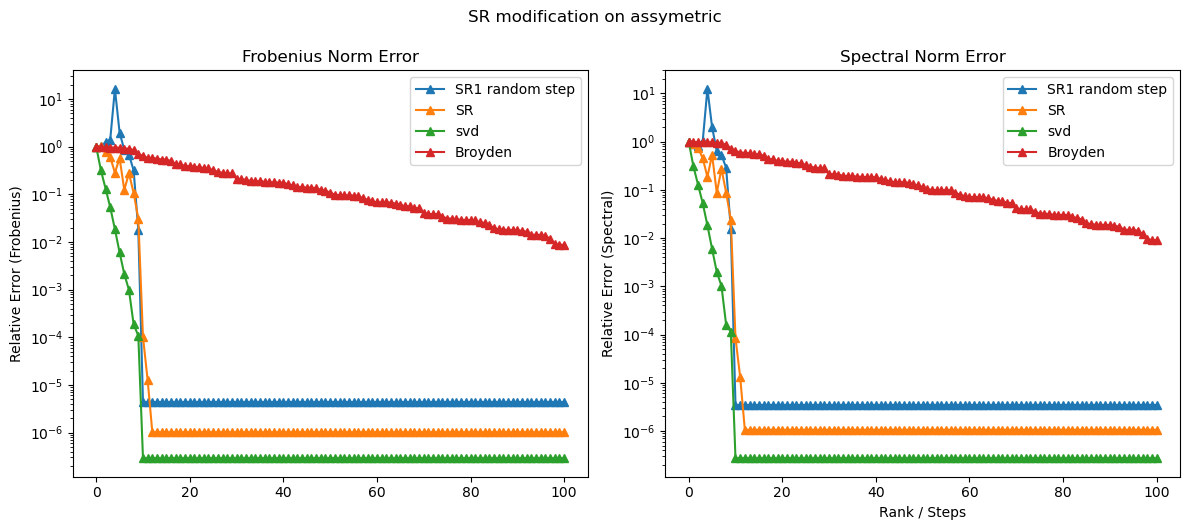

In [563]:
import torch

def generate_matrix_with_spectrum(eigenvalues, symmetric=True, device='cpu'):
    """
    Генерирует квадратную матрицу с заданными собственными значениями.
    
    Параметры:
        eigenvalues (list or Tensor): Заданный спектр (собственные значения).
        symmetric (bool): Если True, матрица будет симметричной (A = A^T).
        device (str): Устройство размещения ('cpu' или 'cuda').

    Возвращает:
        torch.Tensor: Матрица с заданным спектром.
    """
    n = eigenvalues.shape[0]

    # Случайная ортонормированная матрица (ортогональная матрица Q)
    Q, _ = torch.linalg.qr(torch.randn((n, n), device=device))

    # Диагональная матрица со спектром
    D = torch.diag(eigenvalues)

    if symmetric:
        # A = Q D Q^T — симметричная матрица с заданным спектром
        A = Q @ D @ Q.T
        return A
    else:
        max_condition_number = n * max(eigenvalues) / min(eigenvalues)
        D = torch.diag(eigenvalues)

        for _ in range(100):
            # Генерируем случайную обратимую матрицу
            P = torch.randn((n, n), device=device)
            if torch.linalg.matrix_rank(P) < n:
                continue  # пропускаем вырожденную

            try:
                P_inv = torch.inverse(P)
            except RuntimeError:
                continue  # не удалось инвертировать

            A = P @ D @ P_inv

            cond = torch.linalg.cond(A).item()
            if cond <= max_condition_number:
                return A

        raise RuntimeError(
            f"Не удалось сгенерировать матрицу с cond ≤ {max_condition_number} за {100} попыток."
        )

def sr_approximation(s, y, B):
    s = s.view(-1, 1)
    y = y.view(-1, 1)
    denom = (y.T @ s).item()
    if abs(denom) < 1e-1:
        return B
    return B + y @ y.T / denom

def sr1_approximation(s, y, B):
    """
    Build an approximation using the SR1 update:
      B <- B + ((y - B s)(y - B s)^T)/( (y - B s)^T s ).
    """
    s = s.view(-1, 1)
    y = y.view(-1, 1)
    diff = y - B @ s
    denom = (diff.T @ s).item()
    if abs(denom) < 1e-1:
        return B
    return B + (diff @ diff.T) / denom

device = 'cpu'
torch.manual_seed(42)
n = 10
steps = 100

eigenvalues = 2**torch.linspace(12, 1, n) #* torch.tensor([(-1)**m for m in range(n)])
A = generate_matrix_with_spectrum(eigenvalues, symmetric=False, device=device)
A1 = (A + A.T) / 2
# A1 = A
A2 = (A - A.T) / 2
for i in range(n):
    for j in range(i):  # j < i ensures we're below the diagonal
        A2[i, j] *= -1
# A2 = A2 + torch.ones_like(A2)*0.000005


ranks = list(range(0, steps+1))
errors_sr1_fro = [1]
errors_sr1_2   = [1]
errors_sr_fro = [1]
errors_sr_2 = [1]
errors_svd_fro = [1]
errors_svd_2 = [1]
errors_broyden_fro = [1]
errors_broyden_2 = [1]


s1 = torch.randn(n, device=device)
s1 = s1 / torch.norm(s1)
s10 = s1.clone()
y1 = A1@s1
A_sr1_1 = torch.eye(n)

s2 = torch.randn(n, device=device)
s2 = s2 / torch.norm(s2)
s20 = s2.clone()
y2 = A2@s2
A_sr1_2 = torch.eye(n)


for k in range(steps):    
    # --- SR1 approximation ---
    A_sr1_1 = sr1_approximation(s1, y1, A_sr1_1)
    A_sr1_2 = sr1_approximation(s2, y2, A_sr1_2)
    T = A_sr1_2.clone()
    for i in range(n):
        for j in range(i):  # j < i ensures we're below the diagonal
            T[i, j] *= -1
    errors_sr1_fro.append(compute_relative_error(A, A_sr1_1+T, norm_type='fro'))
    errors_sr1_2.append(compute_relative_error(A, A_sr1_1+T, norm_type=2))

    # Update the common s and y vectors.
    # s = torch.randn(n)
    s1 = torch.randn(n, device=device)
    s1 = s1 / torch.norm(s1)
    y1 = A1 @ s1

    s2 = torch.randn(n, device=device)
    s2 = s2 / torch.norm(s2)
    y2 = A2 @ s2


s1 = s10.clone()
A_sr_1 = torch.eye(n)
y1 = (A1-A_sr_1)@s1

s2 = s20.clone()
A_sr_2 = torch.eye(n)
y2 = (A2-A_sr_2)@s2


for k in range(steps):    

    A_sr_1 = sr_approximation(s1, y1, A_sr_1)
    A_sr_2 = sr_approximation(s2, y2, A_sr_2)
    T = A_sr_2.clone()
    for i in range(n):
        for j in range(i):  # j < i ensures we're below the diagonal
            T[i, j] *= -1
    errors_sr_fro.append(compute_relative_error(A, A_sr_1 + T, norm_type='fro'))
    errors_sr_2.append(compute_relative_error(A, A_sr_1 + T, norm_type=2))

    # Update the common s and y vectors.
    s1 = y1.clone()
    s1 = s1 / torch.norm(s1)
    y1 = (A1 - A_sr_1) @ s1

    s2 = y2.clone()
    s2 = s2 / torch.norm(s2)
    y2 = (A2 - A_sr_2) @ s2
    

s = torch.randn(n, device=device)
s = s / torch.norm(s)
y = A@s
A_broyden = torch.eye(n)
A_lincomb = torch.eye(n)
A_app = torch.eye(n)


for k in range(steps):
    # --- Truncated SVD (optimal) approximation with rank = k+1 ---
    A_svd = truncated_svd_approximation(A, rank=k+1)
    errors_svd_fro.append(compute_relative_error(A, A_svd, norm_type='fro'))
    errors_svd_2.append(compute_relative_error(A, A_svd, norm_type=2))
    
    # --- Broyden approximation ---
    A_broyden = broyden_approximation(s, y, A_broyden)
    errors_broyden_fro.append(compute_relative_error(A, A_broyden, norm_type='fro'))
    errors_broyden_2.append(compute_relative_error(A, A_broyden, norm_type=2))
    

    # Update the common s and y vectors.
    s = torch.randn(n)
    # s = y.clone()
    s = s / torch.norm(s)
    y = A @ s

# Plot the errors vs. rank/steps.
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.semilogy(ranks, errors_sr1_fro,     marker='^', label='SR1 random step')
plt.semilogy(ranks, errors_sr_fro,     marker='^', label='SR')
plt.semilogy(ranks, errors_svd_fro,     marker='^', label='svd')
plt.semilogy(ranks, errors_broyden_fro,     marker='^', label='Broyden')
plt.ylabel('Relative Error (Frobenius)')
plt.title('Frobenius Norm Error')
plt.legend()

plt.subplot(1, 2, 2)
plt.semilogy(ranks, errors_sr1_2,     marker='^', label='SR1 random step')
plt.semilogy(ranks, errors_sr_2,     marker='^', label='SR')
plt.semilogy(ranks, errors_svd_2,     marker='^', label='svd')
plt.semilogy(ranks, errors_broyden_2,     marker='^', label='Broyden')
plt.xlabel('Rank / Steps')
plt.ylabel('Relative Error (Spectral)')
plt.title('Spectral Norm Error')
plt.legend()

plt.tight_layout()
plt.suptitle('SR modification on assymetric', y=1.05)
plt.show()

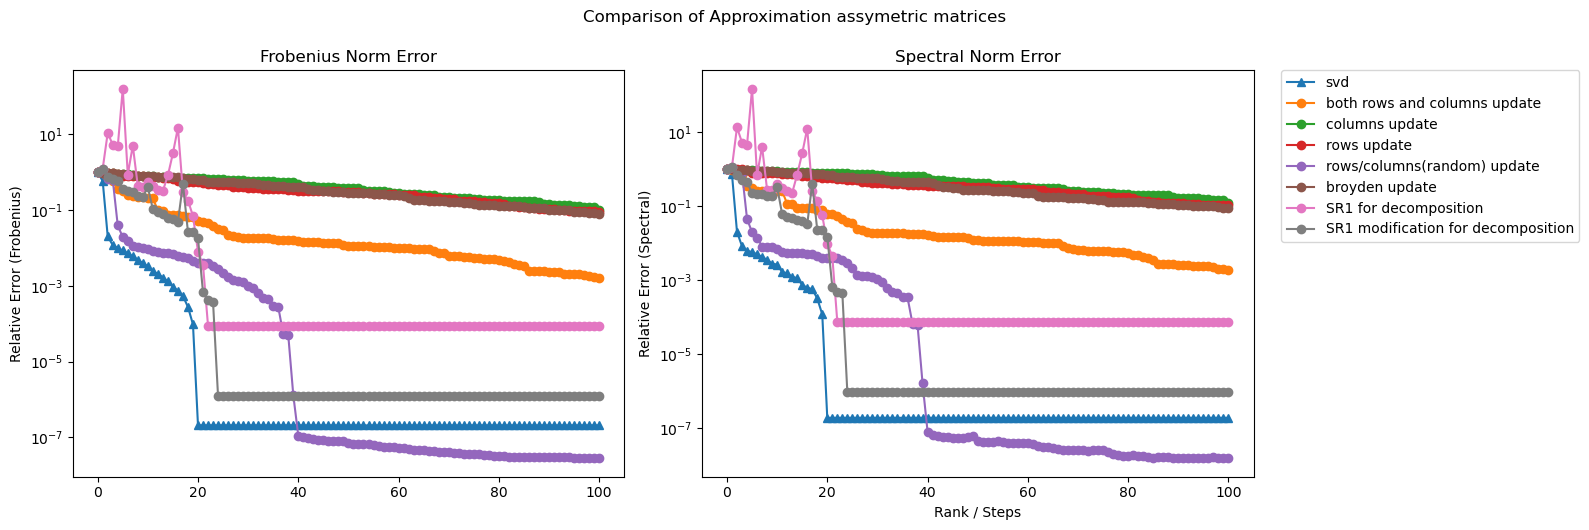

In [575]:
import torch
import matplotlib.pyplot as plt


device = 'cpu'
torch.manual_seed(0)
n = 20
steps = 100

eigenvalues = torch.tensor([1000.]+[500.]+list(2**torch.linspace(4, 1, n-2)))
A = generate_matrix_with_spectrum(eigenvalues, symmetric=False, device=device)

A1 = (A + A.T) / 2
# A1 = A
A2 = (A - A.T) / 2
for i in range(n):
    for j in range(i):  # j < i ensures we're below the diagonal
        A2[i, j] *= -1
        

ranks = list(range(0, steps+1))




errors_svd_fro = [1]
errors_svd_2 = [1]

errors_row_and_cols_fro = [1]
errors_row_and_cols_2 = [1]

errors_rows_fro = [1]
errors_rows_2 = [1]

errors_cols_fro = [1]
errors_cols_2 = [1]

errors_rand_col_row_fro = [1]
errors_rand_col_row_2 = [1]

errors_broyden_fro = [1]
errors_broyden_2 = [1]

errors_sr1_fro = [1]
errors_sr1_2 = [1]

errors_sr_fro = [1]
errors_sr_2 = [1]


def sr_approximation(s, y, B):
    s = s.view(-1, 1)
    y = y.view(-1, 1)
    denom = (y.T @ s).item()
    if abs(denom) < 1e-1:
        return B
    return B + y @ y.T / denom

def row_and_col_approximation(s, y, B):
    s = s.view(-1, 1)
    y = y.view(-1, 1)
    B_ = y @ s.T
    z = (A - B - B_).T @ s
    z = z.view(-1, 1)
    C = s @ z.T
    return B + B_ + C

def col_approximation(s, y, B):
    s = s.view(-1, 1)
    y = y.view(-1, 1)
    B_ = y @ s.T
    return B + B_

def row_approximation(s, y, B):
    s = s.view(-1, 1)
    y = y.view(-1, 1)
    B_ = s @ y.T
    return B + B_

def rand_row_col_approximation(s, y, B):
    if k % 2 == 1:
        return row_approximation(s, y, B)
    return col_approximation(s, y, B)


s_row_and_col = torch.randn(n)
s_row_and_col /= torch.norm(s_row_and_col)
# s_row_and_col = torch.zeros(n)
# s_row_and_col[0] = 1

s_col = s_row_and_col.clone()
s_row = s_row_and_col.clone()
s_rand_row_col = s_row_and_col.clone()
s_broyden = s_row_and_col.clone()
s_sr1_1 = s_row_and_col.clone()
s_sr1_2 = s_row_and_col.clone()
s_sr_1 = s_row_and_col.clone()
s_sr_2 = s_row_and_col.clone()

A_row_and_col = torch.eye(n)
A_col = torch.eye(n)
A_row = torch.eye(n)
A_rand_row_col = torch.eye(n)
A_broyden = torch.eye(n)
A_sr1_1 = torch.eye(n)
A_sr1_2 = torch.eye(n)
A_sr_1 = torch.eye(n)
A_sr_2 = torch.eye(n)

y_row_and_col = (A - A_row_and_col)@s_row_and_col
y_col = (A)@s_col
y_row = (A).T@s_row
y_rand_row_col = (A - A_rand_row_col)@s_rand_row_col
y_broyden = (A)@s_broyden
y_sr1_1 = (A1)@s_sr1_1
y_sr1_2 = (A2)@s_sr1_2
y_sr_1 = (A1-A_sr_1)@s_sr_1
y_sr_2 = (A2-A_sr_2)@s_sr_2


for k in range(steps):    
    A_svd = truncated_svd_approximation(A, rank=k+1)
    errors_svd_fro.append(compute_relative_error(A, A_svd, norm_type='fro'))
    errors_svd_2.append(compute_relative_error(A, A_svd, norm_type=2))

    
    A_row_and_col = row_and_col_approximation(s_row_and_col, y_row_and_col, A_row_and_col)
    errors_row_and_cols_fro.append(compute_relative_error(A, A_row_and_col, norm_type='fro'))
    errors_row_and_cols_2.append(compute_relative_error(A, A_row_and_col, norm_type=2))

    A_col = col_approximation(s_col, y_col, A_col)
    errors_cols_fro.append(compute_relative_error(A, A_col, norm_type='fro'))
    errors_cols_2.append(compute_relative_error(A, A_col, norm_type=2))

    A_row = row_approximation(s_row, y_row, A_row)
    errors_rows_fro.append(compute_relative_error(A, A_row, norm_type='fro'))
    errors_rows_2.append(compute_relative_error(A, A_row, norm_type=2))

    A_rand_row_col = rand_row_col_approximation(s_rand_row_col, y_rand_row_col, A_rand_row_col)
    errors_rand_col_row_fro.append(compute_relative_error(A, A_rand_row_col, norm_type='fro'))
    errors_rand_col_row_2.append(compute_relative_error(A, A_rand_row_col, norm_type=2))

    A_broyden = broyden_approximation(s_broyden, y_broyden, A_broyden)
    errors_broyden_fro.append(compute_relative_error(A, A_broyden, norm_type='fro'))
    errors_broyden_2.append(compute_relative_error(A, A_broyden, norm_type=2))

    A_sr1_1 = sr1_approximation(s_sr1_1, y_sr1_1, A_sr1_1)
    A_sr1_2 = sr1_approximation(s_sr1_2, y_sr1_2, A_sr1_2)
    T = A_sr1_2.clone()
    for i in range(n):
        for j in range(i):  # j < i ensures we're below the diagonal
            T[i, j] *= -1
    errors_sr1_fro.append(compute_relative_error(A, A_sr1_1+T, norm_type='fro'))
    errors_sr1_2.append(compute_relative_error(A, A_sr1_1+T, norm_type=2))

    A_sr_1 = sr_approximation(s_sr_1, y_sr_1, A_sr_1)
    A_sr_2 = sr_approximation(s_sr_2, y_sr_2, A_sr_2)
    T = A_sr_2.clone()
    for i in range(n):
        for j in range(i):  # j < i ensures we're below the diagonal
            T[i, j] *= -1
    errors_sr_fro.append(compute_relative_error(A, A_sr_1+T, norm_type='fro'))
    errors_sr_2.append(compute_relative_error(A, A_sr_1+T, norm_type=2))


    # s = torch.zeros(s.shape)
    # s[np.clip(k+1, a_min=0, a_max=n-1)] = 1
    # s = torch.randn(n)
    s_row_and_col = y_row_and_col.clone() / torch.linalg.norm(y_row_and_col)

    # s_col = y_col.clone() / torch.linalg.norm(y_col)
    s_col = torch.randn(n)
    s_col /= torch.linalg.norm(s_col)
    # s_col = torch.zeros(n)
    # s_col[np.clip(k+1, a_min=0, a_max=n-1)] = 1

    # s_row = y_row.clone() / torch.linalg.norm(y_row)
    s_row = torch.randn(n)
    s_row /= torch.linalg.norm(s_row)
    # s_row = torch.zeros(n)
    # s_row[np.clip(k+1, a_min=0, a_max=n-1)] = 1

    s_rand_row_col = y_rand_row_col.clone() / torch.linalg.norm(y_rand_row_col)

    # s_broyden = y_broyden.clone() / torch.linalg.norm(y_broyden)
    s_broyden = torch.randn(n)
    s_broyden /= torch.linalg.norm(s_broyden)

    s_sr1_1 = torch.randn(n)
    s_sr1_1 /= torch.linalg.norm(s_sr1_1)
    s_sr1_2 = torch.randn(n)
    s_sr1_2 /= torch.linalg.norm(s_sr1_2)

    s_sr_1 = y_sr_1.clone()
    s_sr_1 /= torch.linalg.norm(s_sr_1)
    s_sr_2 = y_sr_2.clone()
    s_sr_2 /= torch.linalg.norm(s_sr_2)



    y_row_and_col = (A - A_row_and_col) @ s_row_and_col
    y_col = (A - A_col) @ s_col
    y_row = (A - A_row).T @ s_row
    if k % 2 == 0:
        y_rand_row_col = (A - A_rand_row_col).T @ s_rand_row_col
    else:
        y_rand_row_col = (A - A_rand_row_col) @ s_rand_row_col
    y_broyden = (A)@s_broyden
    y_sr1_1 = (A1)@s_sr1_1
    y_sr1_2 = (A2)@s_sr1_2
    y_sr_1 = (A1-A_sr_1)@s_sr_1
    y_sr_2 = (A2-A_sr_2)@s_sr_2

# Plot the errors vs. rank/steps.

plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.semilogy(ranks, errors_svd_fro,     marker='^', label='svd')
plt.semilogy(ranks, errors_row_and_cols_fro,   marker='o', label='both rows and columns update')
plt.semilogy(ranks, errors_cols_fro,   marker='o', label='columns update')
plt.semilogy(ranks, errors_rows_fro,   marker='o', label='rows update')
plt.semilogy(ranks, errors_rand_col_row_fro,   marker='o', label='rows/columns(random) update')
plt.semilogy(ranks, errors_broyden_fro,   marker='o', label='broyden update')
plt.semilogy(ranks, errors_sr1_fro,   marker='o', label='SR1 for decomposition')
plt.semilogy(ranks, errors_sr_fro,   marker='o', label='SR1 modification for decomposition')
plt.ylabel('Relative Error (Frobenius)')
plt.title('Frobenius Norm Error')
# plt.legend()

plt.subplot(1, 2, 2)
plt.semilogy(ranks, errors_svd_2,     marker='^', label='svd')
plt.semilogy(ranks, errors_row_and_cols_2,   marker='o', label='both rows and columns update')
plt.semilogy(ranks, errors_cols_2,   marker='o', label='columns update')
plt.semilogy(ranks, errors_rows_2,   marker='o', label='rows update')
plt.semilogy(ranks, errors_rand_col_row_2,   marker='o', label='rows/columns(random) update')
plt.semilogy(ranks, errors_broyden_2,   marker='o', label='broyden update')
plt.semilogy(ranks, errors_sr1_2,   marker='o', label='SR1 for decomposition')
plt.semilogy(ranks, errors_sr_2,   marker='o', label='SR1 modification for decomposition')
plt.xlabel('Rank / Steps')
plt.ylabel('Relative Error (Spectral)')
plt.title('Spectral Norm Error')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.tight_layout()
plt.suptitle('Comparison of Approximation assymetric matrices', y=1.05)
plt.show()

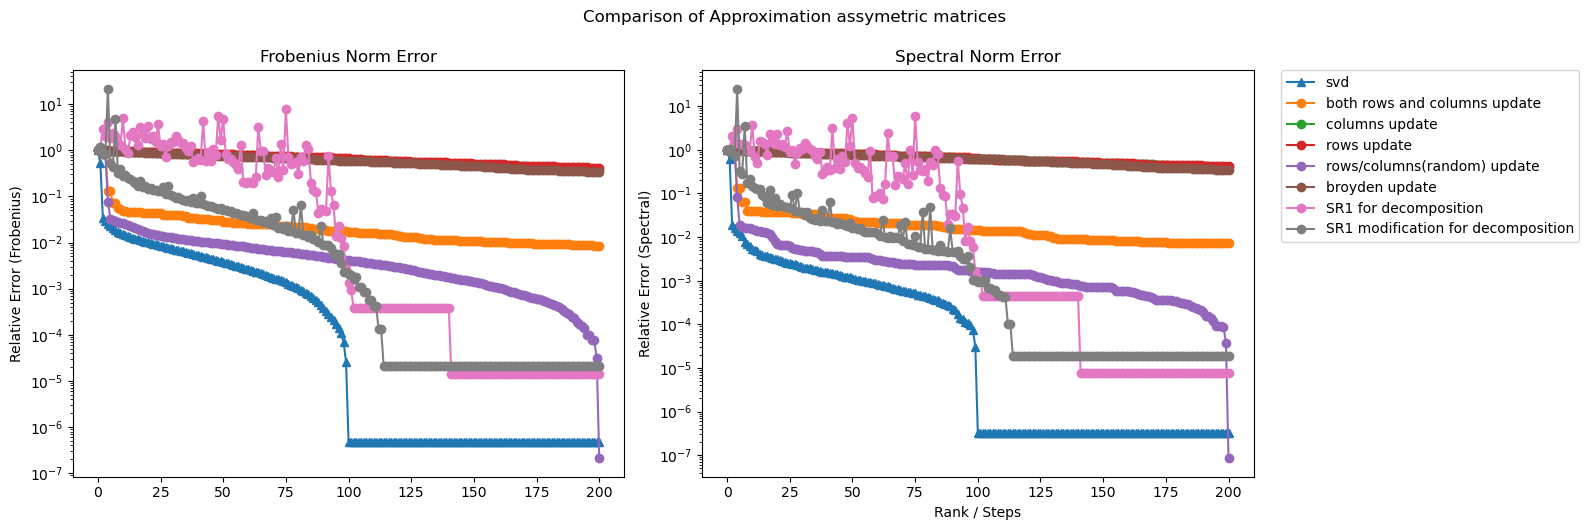

In [576]:
import torch
import matplotlib.pyplot as plt


device = 'cpu'
torch.manual_seed(0)
n = 100
steps = 200

eigenvalues = torch.tensor([1000.]+[500.]+list(2**torch.linspace(4, 1, n-2)))
A = generate_matrix_with_spectrum(eigenvalues, symmetric=False, device=device)

A1 = (A + A.T) / 2
# A1 = A
A2 = (A - A.T) / 2
for i in range(n):
    for j in range(i):  # j < i ensures we're below the diagonal
        A2[i, j] *= -1
        

ranks = list(range(0, steps+1))




errors_svd_fro = [1]
errors_svd_2 = [1]

errors_row_and_cols_fro = [1]
errors_row_and_cols_2 = [1]

errors_rows_fro = [1]
errors_rows_2 = [1]

errors_cols_fro = [1]
errors_cols_2 = [1]

errors_rand_col_row_fro = [1]
errors_rand_col_row_2 = [1]

errors_broyden_fro = [1]
errors_broyden_2 = [1]

errors_sr1_fro = [1]
errors_sr1_2 = [1]

errors_sr_fro = [1]
errors_sr_2 = [1]


def sr_approximation(s, y, B):
    s = s.view(-1, 1)
    y = y.view(-1, 1)
    denom = (y.T @ s).item()
    if abs(denom) < 1e-1:
        return B
    return B + y @ y.T / denom

def row_and_col_approximation(s, y, B):
    s = s.view(-1, 1)
    y = y.view(-1, 1)
    B_ = y @ s.T
    z = (A - B - B_).T @ s
    z = z.view(-1, 1)
    C = s @ z.T
    return B + B_ + C

def col_approximation(s, y, B):
    s = s.view(-1, 1)
    y = y.view(-1, 1)
    B_ = y @ s.T
    return B + B_

def row_approximation(s, y, B):
    s = s.view(-1, 1)
    y = y.view(-1, 1)
    B_ = s @ y.T
    return B + B_

def rand_row_col_approximation(s, y, B):
    if k % 2 == 1:
        return row_approximation(s, y, B)
    return col_approximation(s, y, B)


s_row_and_col = torch.randn(n)
s_row_and_col /= torch.norm(s_row_and_col)
# s_row_and_col = torch.zeros(n)
# s_row_and_col[0] = 1

s_col = s_row_and_col.clone()
s_row = s_row_and_col.clone()
s_rand_row_col = s_row_and_col.clone()
s_broyden = s_row_and_col.clone()
s_sr1_1 = s_row_and_col.clone()
s_sr1_2 = s_row_and_col.clone()
s_sr_1 = s_row_and_col.clone()
s_sr_2 = s_row_and_col.clone()

A_row_and_col = torch.eye(n)
A_col = torch.eye(n)
A_row = torch.eye(n)
A_rand_row_col = torch.eye(n)
A_broyden = torch.eye(n)
A_sr1_1 = torch.eye(n)
A_sr1_2 = torch.eye(n)
A_sr_1 = torch.eye(n)
A_sr_2 = torch.eye(n)

y_row_and_col = (A - A_row_and_col)@s_row_and_col
y_col = (A)@s_col
y_row = (A).T@s_row
y_rand_row_col = (A - A_rand_row_col)@s_rand_row_col
y_broyden = (A)@s_broyden
y_sr1_1 = (A1)@s_sr1_1
y_sr1_2 = (A2)@s_sr1_2
y_sr_1 = (A1-A_sr_1)@s_sr_1
y_sr_2 = (A2-A_sr_2)@s_sr_2


for k in range(steps):    
    A_svd = truncated_svd_approximation(A, rank=k+1)
    errors_svd_fro.append(compute_relative_error(A, A_svd, norm_type='fro'))
    errors_svd_2.append(compute_relative_error(A, A_svd, norm_type=2))

    
    A_row_and_col = row_and_col_approximation(s_row_and_col, y_row_and_col, A_row_and_col)
    errors_row_and_cols_fro.append(compute_relative_error(A, A_row_and_col, norm_type='fro'))
    errors_row_and_cols_2.append(compute_relative_error(A, A_row_and_col, norm_type=2))

    A_col = col_approximation(s_col, y_col, A_col)
    errors_cols_fro.append(compute_relative_error(A, A_col, norm_type='fro'))
    errors_cols_2.append(compute_relative_error(A, A_col, norm_type=2))

    A_row = row_approximation(s_row, y_row, A_row)
    errors_rows_fro.append(compute_relative_error(A, A_row, norm_type='fro'))
    errors_rows_2.append(compute_relative_error(A, A_row, norm_type=2))

    A_rand_row_col = rand_row_col_approximation(s_rand_row_col, y_rand_row_col, A_rand_row_col)
    errors_rand_col_row_fro.append(compute_relative_error(A, A_rand_row_col, norm_type='fro'))
    errors_rand_col_row_2.append(compute_relative_error(A, A_rand_row_col, norm_type=2))

    A_broyden = broyden_approximation(s_broyden, y_broyden, A_broyden)
    errors_broyden_fro.append(compute_relative_error(A, A_broyden, norm_type='fro'))
    errors_broyden_2.append(compute_relative_error(A, A_broyden, norm_type=2))

    A_sr1_1 = sr1_approximation(s_sr1_1, y_sr1_1, A_sr1_1)
    A_sr1_2 = sr1_approximation(s_sr1_2, y_sr1_2, A_sr1_2)
    T = A_sr1_2.clone()
    for i in range(n):
        for j in range(i):  # j < i ensures we're below the diagonal
            T[i, j] *= -1
    errors_sr1_fro.append(compute_relative_error(A, A_sr1_1+T, norm_type='fro'))
    errors_sr1_2.append(compute_relative_error(A, A_sr1_1+T, norm_type=2))

    A_sr_1 = sr_approximation(s_sr_1, y_sr_1, A_sr_1)
    A_sr_2 = sr_approximation(s_sr_2, y_sr_2, A_sr_2)
    T = A_sr_2.clone()
    for i in range(n):
        for j in range(i):  # j < i ensures we're below the diagonal
            T[i, j] *= -1
    errors_sr_fro.append(compute_relative_error(A, A_sr_1+T, norm_type='fro'))
    errors_sr_2.append(compute_relative_error(A, A_sr_1+T, norm_type=2))


    # s = torch.zeros(s.shape)
    # s[np.clip(k+1, a_min=0, a_max=n-1)] = 1
    # s = torch.randn(n)
    s_row_and_col = y_row_and_col.clone() / torch.linalg.norm(y_row_and_col)

    # s_col = y_col.clone() / torch.linalg.norm(y_col)
    s_col = torch.randn(n)
    s_col /= torch.linalg.norm(s_col)
    # s_col = torch.zeros(n)
    # s_col[np.clip(k+1, a_min=0, a_max=n-1)] = 1

    # s_row = y_row.clone() / torch.linalg.norm(y_row)
    s_row = torch.randn(n)
    s_row /= torch.linalg.norm(s_row)
    # s_row = torch.zeros(n)
    # s_row[np.clip(k+1, a_min=0, a_max=n-1)] = 1

    s_rand_row_col = y_rand_row_col.clone() / torch.linalg.norm(y_rand_row_col)

    # s_broyden = y_broyden.clone() / torch.linalg.norm(y_broyden)
    s_broyden = torch.randn(n)
    s_broyden /= torch.linalg.norm(s_broyden)

    s_sr1_1 = torch.randn(n)
    s_sr1_1 /= torch.linalg.norm(s_sr1_1)
    s_sr1_2 = torch.randn(n)
    s_sr1_2 /= torch.linalg.norm(s_sr1_2)

    s_sr_1 = y_sr_1.clone()
    s_sr_1 /= torch.linalg.norm(s_sr_1)
    s_sr_2 = y_sr_2.clone()
    s_sr_2 /= torch.linalg.norm(s_sr_2)



    y_row_and_col = (A - A_row_and_col) @ s_row_and_col
    y_col = (A - A_col) @ s_col
    y_row = (A - A_row).T @ s_row
    if k % 2 == 0:
        y_rand_row_col = (A - A_rand_row_col).T @ s_rand_row_col
    else:
        y_rand_row_col = (A - A_rand_row_col) @ s_rand_row_col
    y_broyden = (A)@s_broyden
    y_sr1_1 = (A1)@s_sr1_1
    y_sr1_2 = (A2)@s_sr1_2
    y_sr_1 = (A1-A_sr_1)@s_sr_1
    y_sr_2 = (A2-A_sr_2)@s_sr_2

# Plot the errors vs. rank/steps.

plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.semilogy(ranks, errors_svd_fro,     marker='^', label='svd')
plt.semilogy(ranks, errors_row_and_cols_fro,   marker='o', label='both rows and columns update')
plt.semilogy(ranks, errors_cols_fro,   marker='o', label='columns update')
plt.semilogy(ranks, errors_rows_fro,   marker='o', label='rows update')
plt.semilogy(ranks, errors_rand_col_row_fro,   marker='o', label='rows/columns(random) update')
plt.semilogy(ranks, errors_broyden_fro,   marker='o', label='broyden update')
plt.semilogy(ranks, errors_sr1_fro,   marker='o', label='SR1 for decomposition')
plt.semilogy(ranks, errors_sr_fro,   marker='o', label='SR1 modification for decomposition')
plt.ylabel('Relative Error (Frobenius)')
plt.title('Frobenius Norm Error')
# plt.legend()

plt.subplot(1, 2, 2)
plt.semilogy(ranks, errors_svd_2,     marker='^', label='svd')
plt.semilogy(ranks, errors_row_and_cols_2,   marker='o', label='both rows and columns update')
plt.semilogy(ranks, errors_cols_2,   marker='o', label='columns update')
plt.semilogy(ranks, errors_rows_2,   marker='o', label='rows update')
plt.semilogy(ranks, errors_rand_col_row_2,   marker='o', label='rows/columns(random) update')
plt.semilogy(ranks, errors_broyden_2,   marker='o', label='broyden update')
plt.semilogy(ranks, errors_sr1_2,   marker='o', label='SR1 for decomposition')
plt.semilogy(ranks, errors_sr_2,   marker='o', label='SR1 modification for decomposition')
plt.xlabel('Rank / Steps')
plt.ylabel('Relative Error (Spectral)')
plt.title('Spectral Norm Error')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.tight_layout()
plt.suptitle('Comparison of Approximation assymetric matrices', y=1.05)
plt.show()

Округлять деноминатор и все равно делать шаг
деноминатор + дельта


1) y = As

    s = (10000)

    B = sy^T

    z = (A-B)^T s

    C = sz^T

    A-B-C - аппрокс


2) y = As

    z = A^Ts

1) Представления несимметр матриц
$$ A = \tfrac{1}{2} (A + A^T) + \tfrac{1}{2} (A - A^T)$$